Toxicity Dataset : https://archive.ics.uci.edu/dataset/728/toxicity-2

The dataset includes 171 molecules designed for functional domains of a core clock protein, CRY1, responsible for generating circadian rhythm. 56 of the molecules are toxic and the rest are non-toxic. 

The data consists a complete set of 1203 molecular descriptors and needs feature selection before classification since some of the features are redundant. 

Introductory Paper:
Structure-based design and classifications of small molecules regulating the circadian rhythm period
By Seref Gul, F. Rahim, Safak Isin, Fatma Yilmaz, Nuri Ozturk, M. Turkay, I. Kavakli. 2021
https://www.semanticscholar.org/paper/Structure-based-design-and-classifications-of-small-Gul-Rahim/5944836c47bc7d1a2b0464a9a1db94d4bc7f28ce

# IMPORTS

In [1]:
pip install ucimlrepo

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import networkx as nx

from ucimlrepo import fetch_ucirepo 

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc, roc_curve,
    classification_report, matthews_corrcoef,
    average_precision_score, balanced_accuracy_score, make_scorer
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn import clone
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier

# For SMOTE (install: pip install imbalanced-learn)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# For statistical testing
from scipy.stats import ttest_rel, wilcoxon

In [3]:
# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

In [4]:
# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# DATA LOAD AND PREPROCESSING

In [5]:
data = fetch_ucirepo(id=728)
X = data.data.features
y = data.data.targets

# Binary encoding: NonToxic=1, Toxic=0
y_binary = (y['Class'] == 'NonToxic').astype(int)

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Feature matrix shape: {X.shape}")
print(f"Number of molecules (n): {X.shape[0]}")
print(f"Number of descriptors (p): {X.shape[1]}")
print(f"Dimensionality ratio (p/n): {X.shape[1]/X.shape[0]:.2f}")
print(f"\nClass distribution:")
print(y['Class'].value_counts())
print(f"\nClass balance:")
for cls, count in y['Class'].value_counts().items():
    pct = count / len(y) * 100
    print(f"  {cls}: {count} ({pct:.2f}%)")

DATASET OVERVIEW
Feature matrix shape: (171, 1203)
Number of molecules (n): 171
Number of descriptors (p): 1203
Dimensionality ratio (p/n): 7.04

Class distribution:
Class
NonToxic    115
Toxic        56
Name: count, dtype: int64

Class balance:
  NonToxic: 115 (67.25%)
  Toxic: 56 (32.75%)


In [6]:
# Check for missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y_binary.isnull().sum()}")


Missing values in features: 0
Missing values in target: 0


# Feature Correlation Analysis


FEATURE CORRELATION ANALYSIS (threshold > 0.9)
Total feature pairs with correlation > 0.9: 3702

Top 10 highest correlations:
Feature1 Feature2  Correlation
 khs.tCH  maxHtCH          1.0
   nHtCH  maxHtCH          1.0
    ntCH  minHtCH          1.0
    ntCH  maxHtCH          1.0
   SHtCH    nHtCH          1.0
   SHtCH     ntCH          1.0
   SHtCH    C2SP1          1.0
   C2SP1  maxHtCH          1.0
   C2SP1  minHtCH          1.0
 minHtCH  khs.tCH          1.0


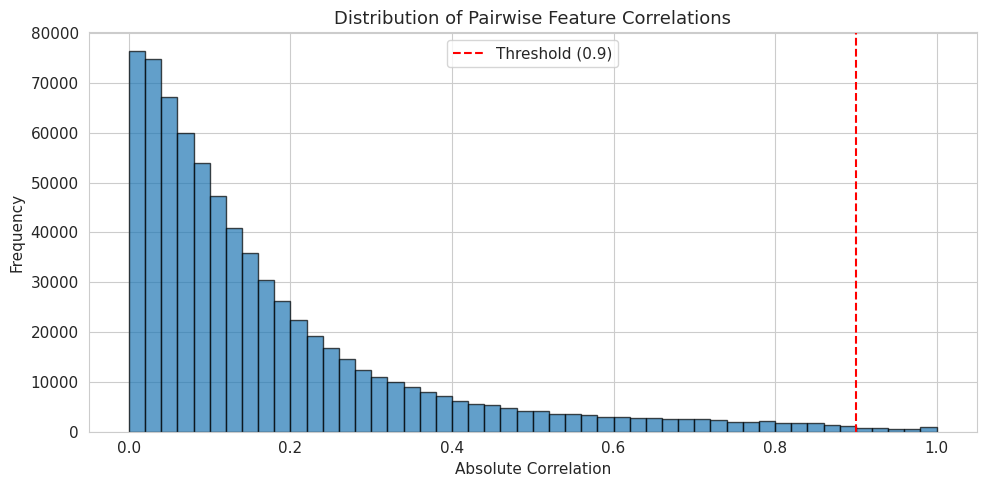


Percentage of feature pairs with |r| > 0.9: 0.51%


In [7]:
def analyze_feature_correlation(X, threshold=0.9):
    """Analyze pairwise feature correlations"""
    corr_matrix = X.corr().abs()
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    high_corr_pairs = []
    for column in upper_tri.columns:
        high_corr_features = upper_tri.index[upper_tri[column] > threshold].tolist()
        for feat in high_corr_features:
            high_corr_pairs.append((column, feat, upper_tri.loc[feat, column]))
    
    print(f"\n{'='*80}")
    print(f"FEATURE CORRELATION ANALYSIS (threshold > {threshold})")
    print("="*80)
    print(f"Total feature pairs with correlation > {threshold}: {len(high_corr_pairs)}")
    
    if len(high_corr_pairs) > 0:
        corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature1', 'Feature2', 'Correlation'])
        corr_df = corr_df.sort_values('Correlation', ascending=False)
        print(f"\nTop 10 highest correlations:")
        print(corr_df.head(10).to_string(index=False))
        
        # Visualize correlation distribution
        all_corrs = upper_tri.values[np.triu_indices_from(upper_tri.values, k=1)]
        all_corrs = all_corrs[~np.isnan(all_corrs)]
        
        plt.figure(figsize=(10, 5))
        plt.hist(all_corrs, bins=50, edgecolor='black', alpha=0.7)
        plt.axvline(threshold, color='red', linestyle='--', 
                   label=f'Threshold ({threshold})')
        plt.xlabel('Absolute Correlation')
        plt.ylabel('Frequency')
        plt.title('Distribution of Pairwise Feature Correlations')
        plt.legend()
        plt.tight_layout()
        plt.savefig('feature_correlation_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        pct_high_corr = (len(high_corr_pairs) / (X.shape[1] * (X.shape[1]-1) / 2)) * 100
        print(f"\nPercentage of feature pairs with |r| > {threshold}: {pct_high_corr:.2f}%")
    
    return high_corr_pairs

high_corr_pairs = analyze_feature_correlation(X, threshold=0.9)


ADVANCED MULTICOLLINEARITY DIAGNOSTICS

1. GLOBAL STABILITY ANALYSIS
   - Condition Number: 1.54e+06
   - Effective Rank (Eigenvalues > 1e-5): 170 / 1203
   -> DIAGNOSIS: Catastrophic Multicollinearity (Ill-conditioned matrix)

2. PAIRWISE REDUNDANCY (r > 0.9)
   - Total Correlated Pairs: 3702
   - Redundant Feature Groups (Clusters): 177
   - Example Largest Cluster (Size 228): ['MPC2', 'ATS5e', 'MPC7', 'SpMax8_Bhm', 'SpMin6_Bhi']...

3. VARIANCE INFLATION FACTOR (VIF) ANALYSIS
   Calculating VIF for all features (this may take a moment)...
   - Severity: 51.0% of features (613/1203) have VIF > 10.0
   - Mean VIF: -12332338171494188375985109793319103234048.00
   - Max VIF:  4755667454624034510111506432.00 (Feature: nF8HeteroRing)


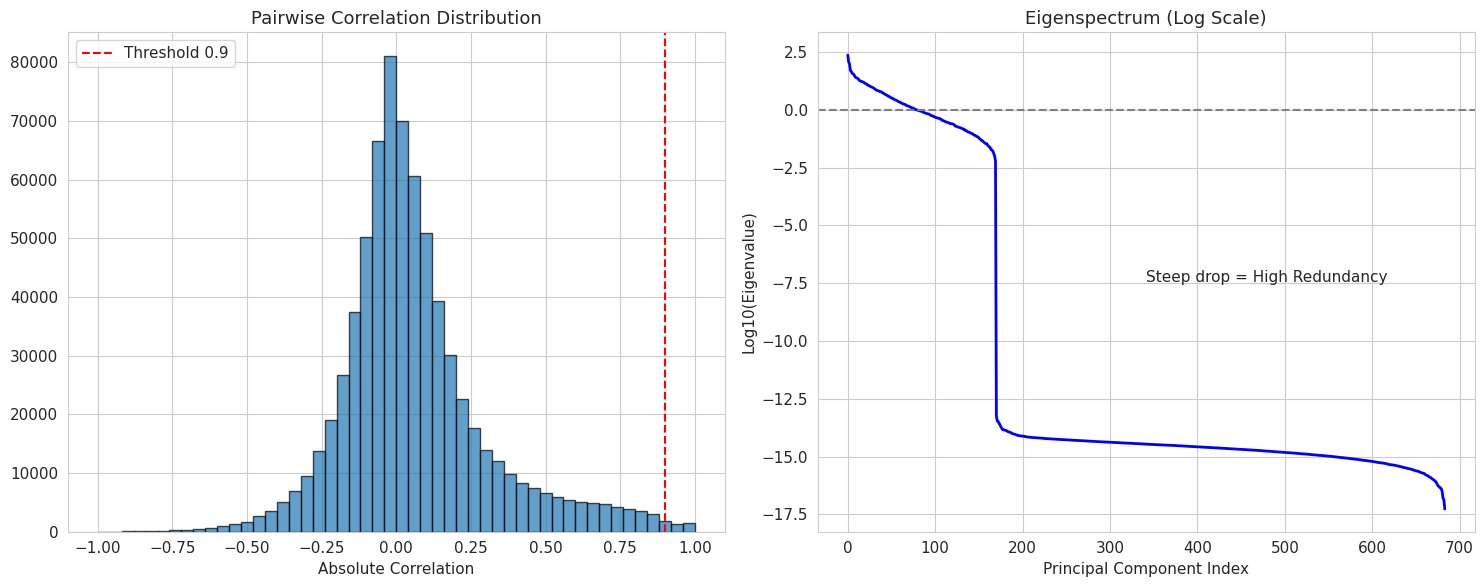

In [8]:
def analyze_multicollinearity_advanced(X, corr_threshold=0.9, vif_threshold=10.0):
    """
    Comprehensive multicollinearity analysis including Pairwise, VIF, and Eigenvalue diagnostics.
    """
    print(f"{'='*80}")
    print(f"ADVANCED MULTICOLLINEARITY DIAGNOSTICS")
    print(f"{'='*80}\n")
    
    n_features = X.shape[1]
    
    # ---------------------------------------------------------
    # 1. Eigenvalue Analysis (Condition Number)
    # ---------------------------------------------------------
    # A condition number > 30 indicates moderate to severe multicollinearity
    # A very high number confirms "mathematically degenerate" matrix
    corr_matrix = X.corr()
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    condition_number = np.sqrt(eigenvalues.max() / (eigenvalues.min() + 1e-10)) # Avoid div by 0
    
    print(f"1. GLOBAL STABILITY ANALYSIS")
    print(f"   - Condition Number: {condition_number:.2e}")
    print(f"   - Effective Rank (Eigenvalues > 1e-5): {np.sum(eigenvalues > 1e-5)} / {n_features}")
    if condition_number > 100:
        print("   -> DIAGNOSIS: Catastrophic Multicollinearity (Ill-conditioned matrix)")
    
    # ---------------------------------------------------------
    # 2. Pairwise Correlation & Grouping (Graph Theory)
    # ---------------------------------------------------------
    # Instead of just listing pairs, we group them into "communities" of redundant features
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_pairs = upper.stack()
    high_corr_pairs = high_corr_pairs[high_corr_pairs.abs() > corr_threshold]
    
    # Create a graph of correlations
    G = nx.Graph()
    for (f1, f2), val in high_corr_pairs.items():
        G.add_edge(f1, f2, weight=val)
    
    components = list(nx.connected_components(G))
    
    print(f"\n2. PAIRWISE REDUNDANCY (r > {corr_threshold})")
    print(f"   - Total Correlated Pairs: {len(high_corr_pairs)}")
    print(f"   - Redundant Feature Groups (Clusters): {len(components)}")
    
    # Show largest cluster example
    if components:
        largest_cluster = max(components, key=len)
        print(f"   - Example Largest Cluster (Size {len(largest_cluster)}): {list(largest_cluster)[:5]}...")

    # ---------------------------------------------------------
    # 3. Variance Inflation Factor (VIF)
    # ---------------------------------------------------------
    # Note: This can be slow for very large N. We use a progress update.
    print(f"\n3. VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
    print("   Calculating VIF for all features (this may take a moment)...")
    
    # Handle infinite VIF by catching errors or checking perfect correlation
    vif_data = []
    
    # We use the correlation matrix inverse diagonal for efficiency if N is large
    # VIF_i = 1 / (1 - R_i^2) = Diagonal of Inverse Correlation Matrix
    try:
        inv_corr = np.linalg.inv(corr_matrix.values)
        vif_values = np.diag(inv_corr)
        vif_series = pd.Series(vif_values, index=corr_matrix.index)
    except np.linalg.LinAlgError:
        print("   ! Matrix is singular. Using pseudo-inverse (approximate VIF).")
        inv_corr = np.linalg.pinv(corr_matrix.values)
        vif_series = pd.Series(np.diag(inv_corr), index=corr_matrix.index)

    # Statistics
    high_vif_count = (vif_series > vif_threshold).sum()
    pct_high_vif = (high_vif_count / n_features) * 100
    
    print(f"   - Severity: {pct_high_vif:.1f}% of features ({high_vif_count}/{n_features}) have VIF > {vif_threshold}")
    print(f"   - Mean VIF: {vif_series.mean():.2f}")
    print(f"   - Max VIF:  {vif_series.max():.2f} (Feature: {vif_series.idxmax()})")

    # ---------------------------------------------------------
    # 4. Visualization (Scree Plot + Histogram)
    # ---------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram of Correlations
    all_corrs = upper.values.flatten()
    all_corrs = all_corrs[~np.isnan(all_corrs)]
    ax1.hist(all_corrs, bins=50, edgecolor='black', alpha=0.7)
    ax1.axvline(corr_threshold, color='red', linestyle='--', label=f'Threshold {corr_threshold}')
    ax1.set_title('Pairwise Correlation Distribution')
    ax1.set_xlabel('Absolute Correlation')
    ax1.legend()
    
    # Scree Plot (Log Eigenvalues)
    ax2.plot(np.arange(len(eigenvalues)), np.log10(eigenvalues[::-1]), 'b-', linewidth=2)
    ax2.axhline(0, color='gray', linestyle='--')
    ax2.set_title('Eigenspectrum (Log Scale)')
    ax2.set_xlabel('Principal Component Index')
    ax2.set_ylabel('Log10(Eigenvalue)')
    ax2.text(0.5, 0.5, 'Steep drop = High Redundancy', transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'high_corr_pairs': high_corr_pairs,
        'vif_data': vif_series,
        'condition_number': condition_number
    }

stats = analyze_multicollinearity_advanced(X)

# Train-Test Split with Stratification

In [8]:
# Shuffle dataset
np.random.seed(RANDOM_STATE)
shuffle_idx = np.random.permutation(len(X))
X_shuffled = X.iloc[shuffle_idx].reset_index(drop=True)
y_shuffled = y_binary.iloc[shuffle_idx].reset_index(drop=True)

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2,
    random_state=RANDOM_STATE, stratify=y_shuffled
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n{'='*80}")
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"\nTraining class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest class distribution:")
print(pd.Series(y_test).value_counts())

feature_names = X.columns.tolist()


TRAIN-TEST SPLIT
Training set: (136, 1203)
Test set: (35, 1203)

Training class distribution:
Class
1    91
0    45
Name: count, dtype: int64

Test class distribution:
Class
1    24
0    11
Name: count, dtype: int64


# SMOTE for Class Imbalance

In [9]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\n{'='*80}")
print("SMOTE RESAMPLING")
print("="*80)
print(f"Original training size: {X_train_scaled.shape}")
print(f"SMOTE training size: {X_train_smote.shape}")
print(f"\nOriginal class distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nSMOTE class distribution:")
print(pd.Series(y_train_smote).value_counts())


SMOTE RESAMPLING
Original training size: (136, 1203)
SMOTE training size: (182, 1203)

Original class distribution:
Class
1    91
0    45
Name: count, dtype: int64

SMOTE class distribution:
Class
0    91
1    91
Name: count, dtype: int64


# MODEL DEFINITIONS WITH HYPERPARAMETER OPTIMIZATION

In [10]:
# Compute class weights for weighted models
class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\n{'='*80}")
print("CLASS WEIGHTS")
print("="*80)
print(f"Class 0 (Toxic): {class_weight_dict[0]:.3f}")
print(f"Class 1 (NonToxic): {class_weight_dict[1]:.3f}")


CLASS WEIGHTS
Class 0 (Toxic): 1.511
Class 1 (NonToxic): 0.747


In [11]:
models = {
    # ===== PENALIZED REGRESSION MODELS =====
    # No penalty
    'LR_No_Penalty': LogisticRegression(penalty=None, max_iter=5000, 
                                        solver='lbfgs', random_state=RANDOM_STATE),
    
    # Ridge (L2) - Multiple C values
    'LR_Ridge_C0.01': LogisticRegression(penalty='l2', C=0.01, max_iter=5000,
                                         solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C0.1': LogisticRegression(penalty='l2', C=0.1, max_iter=5000,
                                        solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C1': LogisticRegression(penalty='l2', C=1.0, max_iter=5000,
                                      solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C10': LogisticRegression(penalty='l2', C=10.0, max_iter=5000,
                                       solver='lbfgs', random_state=RANDOM_STATE),
    'LR_Ridge_C100': LogisticRegression(penalty='l2', C=100.0, max_iter=5000,
                                        solver='lbfgs', random_state=RANDOM_STATE),
    
    # Lasso (L1) - Multiple C values
    'LR_Lasso_C0.001': LogisticRegression(penalty='l1', C=0.001, max_iter=5000,
                                          solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C0.01': LogisticRegression(penalty='l1', C=0.01, max_iter=5000,
                                         solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C0.1': LogisticRegression(penalty='l1', C=0.1, max_iter=5000,
                                        solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C1': LogisticRegression(penalty='l1', C=1.0, max_iter=5000,
                                      solver='saga', random_state=RANDOM_STATE),
    'LR_Lasso_C10': LogisticRegression(penalty='l1', C=10.0, max_iter=5000,
                                       solver='saga', random_state=RANDOM_STATE),
    
    # Elastic Net - Multiple configurations
    'LR_ElasticNet_L1_0.3_C0.1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                     l1_ratio=0.3, C=0.1, max_iter=5000,
                                                     random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.5_C0.1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                     l1_ratio=0.5, C=0.1, max_iter=5000,
                                                     random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.5_C1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                   l1_ratio=0.5, C=1.0, max_iter=5000,
                                                   random_state=RANDOM_STATE),
    'LR_ElasticNet_L1_0.7_C1': LogisticRegression(penalty='elasticnet', solver='saga',
                                                   l1_ratio=0.7, C=1.0, max_iter=5000,
                                                   random_state=RANDOM_STATE),
    
    # Weighted versions of best regularized models
    'LR_Lasso_C0.1_Weighted': LogisticRegression(penalty='l1', C=0.1, max_iter=5000,
                                                 solver='saga', class_weight='balanced',
                                                 random_state=RANDOM_STATE),
    'LR_Ridge_C0.1_Weighted': LogisticRegression(penalty='l2', C=0.1, max_iter=5000,
                                                 solver='lbfgs', class_weight='balanced',
                                                 random_state=RANDOM_STATE),
    
    # Other linear classifiers
    'Ridge_Classifier': RidgeClassifier(alpha=1.0, random_state=RANDOM_STATE),
    'SGD_Classifier': SGDClassifier(loss='log_loss', max_iter=5000, 
                                   random_state=RANDOM_STATE),

    # ===== DISCRIMINANT ANALYSIS =====
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),

    # ===== NAIVE BAYES =====
    'Naive_Bayes': GaussianNB(),

    # ===== TREE-BASED MODELS =====
    'Decision_Tree_D5': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    'Decision_Tree_D10': DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    'Decision_Tree_D20': DecisionTreeClassifier(max_depth=20, random_state=RANDOM_STATE),
    'Decision_Tree_Weighted': DecisionTreeClassifier(max_depth=10, 
                                                     class_weight='balanced',
                                                     random_state=RANDOM_STATE),

    # ===== ENSEMBLE METHODS =====
    # Random Forest
    'Random_Forest_N50': RandomForestClassifier(n_estimators=50, max_depth=10, 
                                                random_state=RANDOM_STATE),
    'Random_Forest_N100': RandomForestClassifier(n_estimators=100, max_depth=10,
                                                 random_state=RANDOM_STATE),
    'Random_Forest_N100_Weighted': RandomForestClassifier(n_estimators=100, max_depth=10,
                                                          class_weight='balanced',
                                                          random_state=RANDOM_STATE),
    'Extra_Trees_N100': ExtraTreesClassifier(n_estimators=100, max_depth=10,
                                            random_state=RANDOM_STATE),

    # Boosting
    'AdaBoost_N50': AdaBoostClassifier(n_estimators=50, random_state=RANDOM_STATE,
                                       algorithm='SAMME'),
    'AdaBoost_N100': AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE,
                                        algorithm='SAMME'),
    'GradientBoosting_N50': GradientBoostingClassifier(n_estimators=50, max_depth=3,
                                                       random_state=RANDOM_STATE),
    'GradientBoosting_N100': GradientBoostingClassifier(n_estimators=100, max_depth=3,
                                                        random_state=RANDOM_STATE),
    'XGBoost_D3_N50': XGBClassifier(max_depth=3, n_estimators=50,
                                   eval_metric='logloss', use_label_encoder=False,
                                   random_state=RANDOM_STATE),
    'XGBoost_D3_N100': XGBClassifier(max_depth=3, n_estimators=100,
                                    eval_metric='logloss', use_label_encoder=False,
                                    random_state=RANDOM_STATE),

    # ===== SUPPORT VECTOR MACHINES =====
    'SVM_Linear': SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
    'SVM_Linear_Weighted': SVC(kernel='linear', probability=True, 
                              class_weight='balanced', random_state=RANDOM_STATE),
    'SVM_RBF_C1': SVC(kernel='rbf', C=1.0, probability=True, random_state=RANDOM_STATE),
    'SVM_RBF_C10': SVC(kernel='rbf', C=10.0, probability=True, random_state=RANDOM_STATE),
    'SVM_Poly_D2': SVC(kernel='poly', degree=2, probability=True, random_state=RANDOM_STATE),
    'SVM_Poly_D3': SVC(kernel='poly', degree=3, probability=True, random_state=RANDOM_STATE),

    # ===== K-NEAREST NEIGHBORS =====
    'KNN_K3': KNeighborsClassifier(n_neighbors=3),
    'KNN_K5': KNeighborsClassifier(n_neighbors=5),
    'KNN_K7': KNeighborsClassifier(n_neighbors=7),
    'KNN_K10': KNeighborsClassifier(n_neighbors=10),

    # ===== NEURAL NETWORKS =====
    'NN_Small': MLPClassifier(hidden_layer_sizes=(25,), max_iter=2000,
                             early_stopping=True, solver='lbfgs', 
                             random_state=RANDOM_STATE),
    'NN_Medium': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=2000,
                              early_stopping=True, solver='lbfgs',
                              random_state=RANDOM_STATE),
    'NN_Large': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=2000,
                             early_stopping=True, solver='lbfgs',
                             random_state=RANDOM_STATE),
    'NN_Adam': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=2000,
                            early_stopping=True, solver='adam',
                            random_state=RANDOM_STATE),
}

print(f"\nTotal models defined: {len(models)}")


Total models defined: 50


# MODEL EVALUATION FUNCTION

In [12]:
def evaluate_model_comprehensive(model, X_train, X_test, y_train, y_test, 
                                model_name="Model"):
    """
    Comprehensive evaluation including:
    - Standard metrics (accuracy, precision, recall, F1, AUC)
    - Matthews Correlation Coefficient (MCC)
    - Confusion matrix
    - Probability calibration check
    """
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probability scores
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_train_proba = model.decision_function(X_train)
        y_test_proba = model.decision_function(X_test)
    else:
        y_train_proba = y_train_pred.astype(float)
        y_test_proba = y_test_pred.astype(float)
    
    # Calculate metrics
    results = {
        'model': model_name,
        'train_acc': accuracy_score(y_train, y_train_pred),
        'test_acc': accuracy_score(y_test, y_test_pred),
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'mcc': matthews_corrcoef(y_test, y_test_pred),
        'pr_auc': average_precision_score(y_test, y_test_proba),
        'bacc': balanced_accuracy_score(y_test, y_test_pred)
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Specificity, Sensitivity, NPV
    results['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    results['sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    results['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Check for majority class prediction
    unique_preds = np.unique(y_test_pred)
    results['predicts_one_class'] = len(unique_preds) == 1
    
    return results, cm

# TRAIN AND EVALUATE ALL MODELS

## STANDARD TRAIN-TEST SPLIT

In [13]:
print("\n" + "="*80)
print("TRAINING MODELS - STANDARD TRAIN-TEST SPLIT")
print("="*80)

results_standard = []
confusion_matrices = {}

for name, model in models.items():
    print(f"Training {name}...", end=" ")
    try:
        metrics, cm = evaluate_model_comprehensive(
            model, X_train_scaled, X_test_scaled, y_train, y_test, name
        )
        results_standard.append(metrics)
        confusion_matrices[name] = cm
        
        # Flag models predicting only one class
        flag = " [⚠ ONE CLASS]" if metrics['predicts_one_class'] else ""
        print(f"mcc: {metrics['mcc']:.4f}, pr_auc: {metrics['pr_auc']:.4f}, bacc: {metrics['bacc']:.4f}{flag}")
    except Exception as e:
        print(f"FAILED: {e}")

results_standard_df = pd.DataFrame(results_standard).sort_values('mcc', ascending=False).reset_index(drop=True)


TRAINING MODELS - STANDARD TRAIN-TEST SPLIT
Training LR_No_Penalty... mcc: 0.1165, pr_auc: 0.7440, bacc: 0.5606
Training LR_Ridge_C0.01... mcc: 0.0187, pr_auc: 0.7744, bacc: 0.5076
Training LR_Ridge_C0.1... mcc: -0.0195, pr_auc: 0.7799, bacc: 0.4905
Training LR_Ridge_C1... mcc: 0.0296, pr_auc: 0.7738, bacc: 0.5152
Training LR_Ridge_C10... mcc: -0.0606, pr_auc: 0.7683, bacc: 0.4697
Training LR_Ridge_C100... mcc: -0.1000, pr_auc: 0.7585, bacc: 0.4489
Training LR_Lasso_C0.001... mcc: 0.0000, pr_auc: 0.6857, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.01... mcc: 0.0000, pr_auc: 0.6857, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.1... mcc: 0.0000, pr_auc: 0.7894, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C1... mcc: 0.0720, pr_auc: 0.7581, bacc: 0.5360
Training LR_Lasso_C10... mcc: 0.0296, pr_auc: 0.7469, bacc: 0.5152
Training LR_ElasticNet_L1_0.3_C0.1... mcc: 0.0712, pr_auc: 0.7212, bacc: 0.5322
Training LR_ElasticNet_L1_0.5_C0.1... mcc: 0.0754, pr_auc: 0.7188, bacc: 0.5284
Trai

In [14]:
results_standard_df

,model,train_acc,test_acc,train_auc,test_auc,precision,recall,f1,mcc,pr_auc,bacc,specificity,sensitivity,npv,predicts_one_class
0,QDA,1.000000,0.628571,1.000000,0.630682,0.789474,0.625000,0.697674,0.243562,0.750564,0.630682,0.636364,0.625000,0.437500,False
1,XGBoost_D3_N50,1.000000,0.657143,1.000000,0.689394,0.750000,0.750000,0.750000,0.204545,0.866304,0.602273,0.454545,0.750000,0.454545,False
2,KNN_K3,0.757353,0.657143,0.779487,0.695076,0.750000,0.750000,0.750000,0.204545,0.825753,0.602273,0.454545,0.750000,0.454545,False
3,Decision_Tree_D5,0.948529,0.628571,0.989866,0.579545,0.761905,0.666667,0.711111,0.201008,0.719526,0.606061,0.545455,0.666667,0.428571,False
4,Random_Forest_N100_Weighted,1.000000,0.685714,1.000000,0.678030,0.724138,0.875000,0.792453,0.181965,0.867135,0.573864,0.272727,0.875000,0.500000,False
5,KNN_K10,0.654412,0.657143,0.682051,0.655303,0.730769,0.791667,0.760000,0.164958,0.806430,0.577652,0.363636,0.791667,0.444444,False
6,GradientBoosting_N100,1.000000,0.657143,1.000000,0.625000,0.730769,0.791667,0.760000,0.164958,0.833974,0.577652,0.363636,0.791667,0.444444,False
7,XGBoost_D3_N100,1.000000,0.657143,1.000000,0.681818,0.730769,0.791667,0.760000,0.164958,0.865483,0.577652,0.363636,0.791667,0.444444,False
8,LDA,0.955882,0.600000,0.993407,0.547348,0.750000,0.625000,0.681818,0.159901,0.708999,0.585227,0.545455,0.625000,0.400000,False
9,Decision_Tree_D20,1.000000,0.600000,1.000000,0.585227,0.750000,0.625000,0.681818,0.159901,0.725893,0.585227,0.545455,0.625000,0.400000,False


## With SMOTE Resampling

In [15]:
print("\n" + "="*80)
print("TRAINING MODELS - WITH SMOTE RESAMPLING")
print("="*80)

results_smote = []

for name, model in models.items():
    # Skip if model doesn't work well with SMOTE
    if 'LDA' in name or 'QDA' in name:
        continue
        
    print(f"Training {name} with SMOTE...", end=" ")
    try:
        metrics, cm = evaluate_model_comprehensive(
            model, X_train_smote, X_test_scaled, y_train_smote, y_test, 
            f"{name}_SMOTE"
        )
        results_smote.append(metrics)
        
        flag = " [⚠ ONE CLASS]" if metrics['predicts_one_class'] else ""
        print(f"mcc: {metrics['mcc']:.4f}, pr_auc: {metrics['pr_auc']:.4f}, bacc: {metrics['bacc']:.4f}{flag}")
    except Exception as e:
        print(f"FAILED: {e}")

results_smote_df = pd.DataFrame(results_smote).sort_values('mcc', ascending=False).reset_index(drop=True)


TRAINING MODELS - WITH SMOTE RESAMPLING
Training LR_No_Penalty with SMOTE... mcc: 0.1599, pr_auc: 0.7446, bacc: 0.5852
Training LR_Ridge_C0.01 with SMOTE... mcc: 0.0296, pr_auc: 0.7354, bacc: 0.5152
Training LR_Ridge_C0.1 with SMOTE... mcc: -0.0606, pr_auc: 0.7836, bacc: 0.4697
Training LR_Ridge_C1 with SMOTE... mcc: 0.0296, pr_auc: 0.7703, bacc: 0.5152
Training LR_Ridge_C10 with SMOTE... mcc: -0.0606, pr_auc: 0.7663, bacc: 0.4697
Training LR_Ridge_C100 with SMOTE... mcc: -0.0109, pr_auc: 0.7645, bacc: 0.4943
Training LR_Lasso_C0.001 with SMOTE... mcc: 0.0000, pr_auc: 0.6857, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.01 with SMOTE... mcc: 0.0000, pr_auc: 0.6857, bacc: 0.5000 [⚠ ONE CLASS]
Training LR_Lasso_C0.1 with SMOTE... mcc: -0.0503, pr_auc: 0.7002, bacc: 0.4735
Training LR_Lasso_C1 with SMOTE... mcc: 0.0296, pr_auc: 0.7541, bacc: 0.5152
Training LR_Lasso_C10 with SMOTE... mcc: 0.0296, pr_auc: 0.7457, bacc: 0.5152
Training LR_ElasticNet_L1_0.3_C0.1 with SMOTE... mcc: 0.1165

In [16]:
results_smote_df

,model,train_acc,test_acc,train_auc,test_auc,precision,recall,f1,mcc,pr_auc,bacc,specificity,sensitivity,npv,predicts_one_class
0,Decision_Tree_Weighted_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
1,Decision_Tree_D10_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
2,Decision_Tree_D20_SMOTE,1.000000,0.714286,1.000000,0.693182,0.818182,0.750000,0.782609,0.371206,0.785065,0.693182,0.636364,0.750000,0.538462,False
3,Decision_Tree_D5_SMOTE,0.928571,0.685714,0.947470,0.715909,0.842105,0.666667,0.744186,0.367109,0.792992,0.696970,0.727273,0.666667,0.500000,False
4,KNN_K3_SMOTE,0.769231,0.542857,0.928149,0.645833,0.833333,0.416667,0.555556,0.229686,0.790580,0.617424,0.818182,0.416667,0.391304,False
5,SVM_Poly_D3_SMOTE,0.785714,0.400000,0.979230,0.541667,1.000000,0.125000,0.222222,0.207289,0.762223,0.562500,1.000000,0.125000,0.343750,False
6,NN_Small_SMOTE,1.000000,0.657143,1.000000,0.672348,0.750000,0.750000,0.750000,0.204545,0.832904,0.602273,0.454545,0.750000,0.454545,False
7,GradientBoosting_N50_SMOTE,1.000000,0.600000,1.000000,0.689394,0.777778,0.583333,0.666667,0.204063,0.862702,0.609848,0.636364,0.583333,0.411765,False
8,AdaBoost_N50_SMOTE,1.000000,0.628571,1.000000,0.609848,0.761905,0.666667,0.711111,0.201008,0.820031,0.606061,0.545455,0.666667,0.428571,False
9,SVM_Poly_D2_SMOTE,0.868132,0.571429,0.966308,0.632576,0.764706,0.541667,0.634146,0.165362,0.815875,0.589015,0.636364,0.541667,0.388889,False


In [17]:
results_combined_df = pd.concat([results_standard_df, results_smote_df], 
                                ignore_index=True)
results_combined_df = results_combined_df.sort_values('test_auc', 
                                                       ascending=False).reset_index(drop=True)

# Nested Cross-Validation

In [ ]:
def nested_cross_validation(model, X, y, inner_cv=5, outer_cv=5, param_grid=None, 
                            scoring_metric='roc_auc', n_jobs=-1):
    """
    Improved nested CV with:
    - Configurable inner scoring metric (use MCC for imbalanced data)
    - 95% confidence intervals
    - Hyperparameter stability tracking
    - Statistical comparison to baseline
    - Proper handling of failed folds
    """
    from sklearn.model_selection import GridSearchCV
    from scipy import stats
    
    outer_skf = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=RANDOM_STATE)
    
    outer_scores = {
        'test_accuracy': [],
        'test_auc': [],
        'test_f1': [],
        'test_mcc': [],
        'test_pr_auc': [],
        'test_bacc': [],
        'test_sensitivity': [],
        'test_specificity': [],
        'test_precision': [],
        'best_params': [],
        'n_selected_features': []
    }
    
    fold_idx = 0
    for train_idx, test_idx in outer_skf.split(X, y):
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
        
        try:
            if param_grid:
                inner_skf = StratifiedKFold(n_splits=inner_cv, shuffle=True, 
                                           random_state=RANDOM_STATE + fold_idx)
                
                # Map scoring_metric to appropriate scorer
                if scoring_metric == 'mcc':
                    scorer = make_scorer(matthews_corrcoef)
                elif scoring_metric == 'roc_auc':
                    scorer = 'roc_auc'
                elif scoring_metric == 'f1':
                    scorer = 'f1'
                else:
                    scorer = scoring_metric
                
                grid_search = RandomizedSearchCV(
                    model, 
                    param_grid, 
                    n_iter=20,
                    cv=inner_skf, 
                    scoring=scorer,
                    n_jobs=n_jobs,
                    return_train_score=False
                )
                grid_search.fit(X_train_outer, y_train_outer)
                best_model = grid_search.best_estimator_
                outer_scores['best_params'].append(grid_search.best_params_)
            else:
                best_model = clone(model)
                best_model.fit(X_train_outer, y_train_outer)
                outer_scores['best_params'].append({})
            
            y_pred = best_model.predict(X_test_outer)
            
            if hasattr(best_model, 'predict_proba'):
                y_proba = best_model.predict_proba(X_test_outer)[:, 1]
            else:
                y_proba = best_model.decision_function(X_test_outer)
                y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
            
            tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            
            outer_scores['test_accuracy'].append(accuracy_score(y_test_outer, y_pred))
            outer_scores['test_auc'].append(roc_auc_score(y_test_outer, y_proba))
            outer_scores['test_f1'].append(f1_score(y_test_outer, y_pred))
            outer_scores['test_mcc'].append(matthews_corrcoef(y_test_outer, y_pred))
            outer_scores['test_pr_auc'].append(average_precision_score(y_test_outer, y_proba))
            outer_scores['test_bacc'].append(balanced_accuracy_score(y_test_outer, y_pred))
            outer_scores['test_sensitivity'].append(sensitivity)
            outer_scores['test_specificity'].append(specificity)
            outer_scores['test_precision'].append(precision)
            
            if hasattr(best_model, 'coef_'):
                n_selected = np.sum(np.abs(best_model.coef_[0]) > 1e-5)
                outer_scores['n_selected_features'].append(n_selected)
            else:
                outer_scores['n_selected_features'].append(X.shape[1])
                
        except Exception as e:
            print(f"    Fold {fold_idx} failed: {str(e)[:50]}")
            continue
        
        fold_idx += 1
    
    if len(outer_scores['test_mcc']) == 0:
        return None
    
    def calculate_ci(scores, confidence=0.95):
        n = len(scores)
        mean = np.mean(scores)
        std_err = stats.sem(scores)
        ci = std_err * stats.t.ppf((1 + confidence) / 2., n - 1)
        return mean, std_err, (mean - ci, mean + ci)
    
    mcc_mean, mcc_se, mcc_ci = calculate_ci(outer_scores['test_mcc'])
    pr_auc_mean, pr_auc_se, pr_auc_ci = calculate_ci(outer_scores['test_pr_auc'])
    bacc_mean, bacc_se, bacc_ci = calculate_ci(outer_scores['test_bacc'])
    
    from collections import Counter
    param_stability = {}
    if outer_scores['best_params']:
        for param_name in outer_scores['best_params'][0].keys():
            param_values = [p[param_name] for p in outer_scores['best_params']]
            most_common = Counter(param_values).most_common(1)[0]
            param_stability[param_name] = {
                'most_common': most_common[0],
                'frequency': most_common[1] / len(param_values)
            }
    
    return {
        'mean_accuracy': np.mean(outer_scores['test_accuracy']),
        'std_accuracy': np.std(outer_scores['test_accuracy']),
        'mean_auc': np.mean(outer_scores['test_auc']),
        'std_auc': np.std(outer_scores['test_auc']),
        'mean_f1': np.mean(outer_scores['test_f1']),
        'std_f1': np.std(outer_scores['test_f1']),
        'mean_mcc': mcc_mean,
        'std_mcc': np.std(outer_scores['test_mcc']),
        'se_mcc': mcc_se,
        'ci_mcc_lower': mcc_ci[0],
        'ci_mcc_upper': mcc_ci[1],
        'mean_pr_auc': pr_auc_mean,
        'std_pr_auc': np.std(outer_scores['test_pr_auc']),
        'se_pr_auc': pr_auc_se,
        'ci_pr_auc_lower': pr_auc_ci[0],
        'ci_pr_auc_upper': pr_auc_ci[1],
        'mean_bacc': bacc_mean,
        'std_bacc': np.std(outer_scores['test_bacc']),
        'se_bacc': bacc_se,
        'ci_bacc_lower': bacc_ci[0],
        'ci_bacc_upper': bacc_ci[1],
        'mean_sensitivity': np.mean(outer_scores['test_sensitivity']),
        'mean_specificity': np.mean(outer_scores['test_specificity']),
        'mean_precision': np.mean(outer_scores['test_precision']),
        'mean_n_features': np.mean(outer_scores['n_selected_features']),
        'std_n_features': np.std(outer_scores['n_selected_features']),
        'param_stability': param_stability,
        'all_params': outer_scores['best_params'],
        'n_folds_completed': len(outer_scores['test_mcc'])
    }




In [20]:
print("\n" + "="*80)
print("NESTED CV - COMPREHENSIVE MODEL COMPARISON")
print("="*80)

hyperparameter_grids = {
    # LINEAR MODELS (Interpretable)
    'Ridge': {
        'model': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, 
                                   random_state=RANDOM_STATE),
        'params': {
            'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            'class_weight': [None, 'balanced']
        }
    },
    'Lasso': {
        'model': LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, 
                                   random_state=RANDOM_STATE),
        'params': {
            'C': [0.001, 0.01, 0.1, 1.0, 10.0],
            'class_weight': [None, 'balanced']
        }
    },
    'ElasticNet': {
        'model': LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, 
                                    tol=1e-3, warm_start=True, random_state=RANDOM_STATE),
        'params': {
            'C': [0.01, 0.1, 1.0, 10.0],
            'l1_ratio': [0.3, 0.5, 0.7, 0.9],
            'class_weight': [None, 'balanced']
        }
    },
    
    # NON-LINEAR MODELS (Predictive)
    'RandomForest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': [None, 'balanced']
        }
    },
    
    'XGBoost': {
        'model': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, 
                                   eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.5, 0.7, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0],
            'scale_pos_weight': [1, len(y_train[y_train==0])/len(y_train[y_train==1])]
        }
    },
    
    'KNN': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'n_neighbors': [3, 5, 7, 10, 15],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    
    'QDA': {
        'model': QuadraticDiscriminantAnalysis(),
        'params': {
            'reg_param': [0.0, 0.1, 0.3, 0.5, 0.7]
        }
    },
    
    'SVM_RBF': {
        'model': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'gamma': ['scale', 'auto', 0.01, 0.1],
            'class_weight': [None, 'balanced']
        }
    },
    
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': [None, 'balanced']
        }
    },
    
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.7, 1.0]
        }
    }
}


nested_cv_results = []

for model_name, config in hyperparameter_grids.items():
    print(f"\nNested CV: {model_name}...", end=" ")
    
    try:
        metrics = nested_cross_validation(
            config['model'], 
            X_train_scaled, 
            y_train, 
            inner_cv=5, 
            outer_cv=5, 
            param_grid=config['params'],
            n_jobs=-1
        )
        
        if metrics is None:
            print(f"✗ All folds failed")
            continue
            
        metrics['model'] = model_name
        metrics['model_type'] = 'Linear' if model_name in ['Ridge', 'Lasso', 'ElasticNet'] else 'Non-Linear'
        nested_cv_results.append(metrics)
        
        print(f"✓ MCC: {metrics['mean_mcc']:.3f} [{metrics['ci_mcc_lower']:.3f}, {metrics['ci_mcc_upper']:.3f}], "
              f"PR-AUC: {metrics['mean_pr_auc']:.3f}")
            
    except Exception as e:
        print(f"✗ FAILED: {str(e)}")




NESTED CV - COMPREHENSIVE MODEL COMPARISON

Nested CV: Ridge... ✓ MCC: -0.186 [-0.546, 0.174], PR-AUC: 0.658

Nested CV: Lasso... ✓ MCC: -0.076 [-0.287, 0.135], PR-AUC: 0.653

Nested CV: ElasticNet... ✓ MCC: -0.099 [-0.303, 0.106], PR-AUC: 0.667

Nested CV: RandomForest... ✓ MCC: -0.039 [-0.221, 0.142], PR-AUC: 0.697

Nested CV: XGBoost... ✓ MCC: -0.061 [-0.337, 0.216], PR-AUC: 0.660

Nested CV: KNN... ✓ MCC: -0.178 [-0.432, 0.076], PR-AUC: 0.669

Nested CV: QDA... ✓ MCC: -0.019 [-0.188, 0.151], PR-AUC: 0.677

Nested CV: SVM_RBF... ✓ MCC: -0.043 [-0.164, 0.077], PR-AUC: 0.740

Nested CV: DecisionTree... ✓ MCC: -0.036 [-0.297, 0.224], PR-AUC: 0.664

Nested CV: GradientBoosting... ✓ MCC: -0.099 [-0.370, 0.172], PR-AUC: 0.694


In [21]:
# Analyze by model type
if nested_cv_results:
    nested_cv_results_df = pd.DataFrame(nested_cv_results)
    
    print("\n" + "="*80)
    print("RESULTS BY MODEL TYPE")
    print("="*80)
    
    for model_type in ['Linear', 'Non-Linear']:
        type_df = nested_cv_results_df[nested_cv_results_df['model_type'] == model_type]
        if len(type_df) > 0:
            print(f"\n{model_type} Models:")
            print(f"  Best MCC: {type_df['mean_mcc'].max():.3f} ({type_df.loc[type_df['mean_mcc'].idxmax(), 'model']})")
            print(f"  Best PR-AUC: {type_df['mean_pr_auc'].max():.3f} ({type_df.loc[type_df['mean_pr_auc'].idxmax(), 'model']})")
    
    print("\n" + "="*80)
    print("TOP 10 MODELS (RANKED BY MCC)")
    print("="*80)
    
    top10 = nested_cv_results_df.nlargest(10, 'mean_mcc')[
        ['model', 'model_type', 'mean_mcc', 'ci_mcc_lower', 'ci_mcc_upper', 
         'mean_pr_auc', 'mean_bacc', 'mean_n_features']
    ]
    print(top10.to_string(index=False))



RESULTS BY MODEL TYPE

Linear Models:
  Best MCC: -0.076 (Lasso)
  Best PR-AUC: 0.667 (ElasticNet)

Non-Linear Models:
  Best MCC: -0.019 (QDA)
  Best PR-AUC: 0.740 (SVM_RBF)

TOP 10 MODELS (RANKED BY MCC)
           model model_type  mean_mcc  ci_mcc_lower  ci_mcc_upper  mean_pr_auc  mean_bacc  mean_n_features
             QDA Non-Linear -0.018551     -0.188023      0.150920     0.677224   0.500000           1203.0
    DecisionTree Non-Linear -0.036425     -0.296514      0.223663     0.663514   0.484795           1203.0
    RandomForest Non-Linear -0.039456     -0.221228      0.142317     0.696783   0.484211           1203.0
         SVM_RBF Non-Linear -0.043386     -0.163845      0.077073     0.739631   0.477778           1203.0
         XGBoost Non-Linear -0.060523     -0.336744      0.215698     0.660090   0.474854           1203.0
           Lasso     Linear -0.075926     -0.286729      0.134878     0.652754   0.461111             17.6
GradientBoosting Non-Linear -0.098655     -0

In [22]:
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON (NESTED CV)")
print("="*80)

comparison_df = nested_cv_results_df[[
    'model', 'model_type', 
    'mean_mcc', 'ci_mcc_lower', 'ci_mcc_upper',
    'mean_pr_auc', 'ci_pr_auc_lower', 'ci_pr_auc_upper',
    'mean_bacc', 'mean_sensitivity', 'mean_specificity',
    'mean_n_features', 'n_folds_completed'
]].copy()

comparison_df['mcc_significant'] = comparison_df['ci_mcc_lower'] > 0
comparison_df = comparison_df.sort_values('mean_mcc', ascending=False)

print(comparison_df.to_string(index=False))

best_overall = comparison_df.iloc[0]
best_linear = comparison_df[comparison_df['model_type'] == 'Linear'].iloc[0]

print(f"\n✓ Best Overall: {best_overall['model']} (MCC={best_overall['mean_mcc']:.3f})")
print(f"✓ Best Linear: {best_linear['model']} (MCC={best_linear['mean_mcc']:.3f})")
print(f"✓ Performance Gap: {(best_overall['mean_mcc'] - best_linear['mean_mcc']):.3f}")


COMPREHENSIVE MODEL COMPARISON (NESTED CV)
           model model_type  mean_mcc  ci_mcc_lower  ci_mcc_upper  mean_pr_auc  ci_pr_auc_lower  ci_pr_auc_upper  mean_bacc  mean_sensitivity  mean_specificity  mean_n_features  n_folds_completed  mcc_significant
             QDA Non-Linear -0.018551     -0.188023      0.150920     0.677224         0.597775         0.756672   0.500000          0.222222          0.777778           1203.0                  5            False
    DecisionTree Non-Linear -0.036425     -0.296514      0.223663     0.663514         0.585151         0.741876   0.484795          0.658480          0.311111           1203.0                  5            False
    RandomForest Non-Linear -0.039456     -0.221228      0.142317     0.696783         0.632992         0.760574   0.484211          0.812865          0.155556           1203.0                  5            False
         SVM_RBF Non-Linear -0.043386     -0.163845      0.077073     0.739631         0.650920         

# STATISTICAL SIGNIFICANCE TESTING 

In [23]:
print("\n" + "="*80)
print("PAIRWISE STATISTICAL COMPARISONS (TOP 5 MODELS)")
print("="*80)

top5 = comparison_df.head(5)
significance_matrix = np.ones((len(top5), len(top5)))

for i in range(len(top5)):
    for j in range(i+1, len(top5)):
        model_i = top5.iloc[i]
        model_j = top5.iloc[j]
        
        ci_i = (model_i['ci_mcc_lower'], model_i['ci_mcc_upper'])
        ci_j = (model_j['ci_mcc_lower'], model_j['ci_mcc_upper'])
        
        ci_overlap = ci_i[0] <= ci_j[1] and ci_j[0] <= ci_i[1]
        significance_matrix[i, j] = 1 if ci_overlap else 0
        significance_matrix[j, i] = significance_matrix[i, j]
        
        print(f"\n{model_i['model']} vs {model_j['model']}:")
        print(f"  MCC: {model_i['mean_mcc']:.3f} vs {model_j['mean_mcc']:.3f}")
        print(f"  Difference: {abs(model_i['mean_mcc'] - model_j['mean_mcc']):.3f}")
        print(f"  95% CI Overlap: {'Yes (no sig diff)' if ci_overlap else 'No (significant)'}")



PAIRWISE STATISTICAL COMPARISONS (TOP 5 MODELS)

QDA vs DecisionTree:
  MCC: -0.019 vs -0.036
  Difference: 0.018
  95% CI Overlap: Yes (no sig diff)

QDA vs RandomForest:
  MCC: -0.019 vs -0.039
  Difference: 0.021
  95% CI Overlap: Yes (no sig diff)

QDA vs SVM_RBF:
  MCC: -0.019 vs -0.043
  Difference: 0.025
  95% CI Overlap: Yes (no sig diff)

QDA vs XGBoost:
  MCC: -0.019 vs -0.061
  Difference: 0.042
  95% CI Overlap: Yes (no sig diff)

DecisionTree vs RandomForest:
  MCC: -0.036 vs -0.039
  Difference: 0.003
  95% CI Overlap: Yes (no sig diff)

DecisionTree vs SVM_RBF:
  MCC: -0.036 vs -0.043
  Difference: 0.007
  95% CI Overlap: Yes (no sig diff)

DecisionTree vs XGBoost:
  MCC: -0.036 vs -0.061
  Difference: 0.024
  95% CI Overlap: Yes (no sig diff)

RandomForest vs SVM_RBF:
  MCC: -0.039 vs -0.043
  Difference: 0.004
  95% CI Overlap: Yes (no sig diff)

RandomForest vs XGBoost:
  MCC: -0.039 vs -0.061
  Difference: 0.021
  95% CI Overlap: Yes (no sig diff)

SVM_RBF vs XGBoos

# FEATURE IMPORTANCE ANALYSIS

In [24]:
original_features = ['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 
                    'SpMax7_Bhe', 'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 
                    'SpMax5_Bhv', 'VE3_Dzi', 'VPC-4']

def get_feature_importance(model, X_train, X_test, y_train, y_test):
    """Extract feature importance using multiple methods"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        method = "Built-in"
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        method = "Coefficients"
    else:
        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=10,
            random_state=RANDOM_STATE, n_jobs=-1
        )
        importances = perm_importance.importances_mean
        method = "Permutation"
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    return importance_df, method


# VIF ANALYSIS (MULTICOLLINEARITY)

In [25]:
def calculate_vif_analysis(X, feature_names, max_vif_threshold=10, 
                          high_vif_threshold=5, name="Dataset"):
    """
    Comprehensive VIF analysis for multicollinearity detection
    
    VIF Interpretation:
    - VIF = 1: No correlation with other predictors
    - 1 < VIF ≤ 5: Moderate multicollinearity (generally acceptable)
    - VIF > 5: Serious multicollinearity (consider removing feature)
    - VIF > 10: Severe multicollinearity (should remove feature)
    """
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = feature_names
    vif_data["VIF"] = [variance_inflation_factor(X, i) 
                       for i in range(X.shape[1])]
    
    vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
    
    # Categorize by severity
    vif_data['Severity'] = vif_data['VIF'].apply(
        lambda x: 'Severe' if x > max_vif_threshold else 
                 'Serious' if x > high_vif_threshold else 
                 'Moderate' if x > 1 else 'Low'
    )
    
    # Summary statistics
    severe_count = (vif_data['VIF'] > max_vif_threshold).sum()
    serious_count = ((vif_data['VIF'] > high_vif_threshold) & 
                     (vif_data['VIF'] <= max_vif_threshold)).sum()
    moderate_count = ((vif_data['VIF'] > 1) & 
                      (vif_data['VIF'] <= high_vif_threshold)).sum()
    low_count = (vif_data['VIF'] <= 1).sum()
    
    print(f"\n>>> {name}")
    print(f"{'='*80}")
    print(f"Total features: {len(vif_data)}")
    print(f"\nMulticollinearity Severity Distribution:")
    print(f"  Severe (VIF > 10):     {severe_count:3d} features ({severe_count/len(vif_data)*100:5.1f}%)")
    print(f"  Serious (5 < VIF ≤ 10):{serious_count:3d} features ({serious_count/len(vif_data)*100:5.1f}%)")
    print(f"  Moderate (1 < VIF ≤ 5):{moderate_count:3d} features ({moderate_count/len(vif_data)*100:5.1f}%)")
    print(f"  Low (VIF ≤ 1):        {low_count:3d} features ({low_count/len(vif_data)*100:5.1f}%)")
    
    print(f"\nVIF Statistics:")
    print(f"  Mean VIF:   {vif_data['VIF'].mean():.2f}")
    print(f"  Median VIF: {vif_data['VIF'].median():.2f}")
    print(f"  Max VIF:    {vif_data['VIF'].max():.2f}")
    print(f"  Min VIF:    {vif_data['VIF'].min():.2f}")
    
    print(f"\nTop 20 Features by VIF:")
    print(vif_data.head(20).to_string(index=False))
    
    if severe_count > 0:
        print(f"\n⚠ WARNING: {severe_count} features have severe multicollinearity (VIF > 10)")
        print(f"   These features may be redundant - consider removal in feature selection")
    
    if serious_count > 0:
        print(f"\n⚠ Note: {serious_count} features have serious multicollinearity (5 < VIF ≤ 10)")
    
    return vif_data


In [26]:
vif_full = calculate_vif_analysis(X_train_scaled, feature_names, name="Full Feature Set (All 1203 Features)")


>>> Full Feature Set (All 1203 Features)
Total features: 1203

Multicollinearity Severity Distribution:
  Severe (VIF > 10):     1198 features ( 99.6%)
  Serious (5 < VIF ≤ 10):  0 features (  0.0%)
  Moderate (1 < VIF ≤ 5):  0 features (  0.0%)
  Low (VIF ≤ 1):          0 features (  0.0%)

VIF Statistics:
  Mean VIF:   13696887.50
  Median VIF: 10853503.28
  Max VIF:    87121434.38
  Min VIF:    1713543.74

Top 20 Features by VIF:
     Feature          VIF Severity
      GATS8p 8.712143e+07   Severe
      MATS5p 7.721997e+07   Severe
     maxdsCH 6.129153e+07   Severe
     AATSC6e 5.948989e+07   Severe
     AATSC5p 5.862592e+07   Severe
n7HeteroRing 5.799111e+07   Severe
        GGI4 5.656169e+07   Severe
    nT11Ring 5.612606e+07   Severe
        WPOL 5.288888e+07   Severe
    minsssCH 5.263945e+07   Severe
      MAXDN2 5.230662e+07   Severe
   ETA_Eta_F 5.222980e+07   Severe
    ETA_Beta 5.198419e+07   Severe
      MATS2s 5.179605e+07   Severe
        gmax 5.173674e+07   Severe
  

In [27]:
vif_train = calculate_vif_analysis(X_train_scaled, feature_names, name="Training Set (Scaled)")


>>> Training Set (Scaled)
Total features: 1203

Multicollinearity Severity Distribution:
  Severe (VIF > 10):     1198 features ( 99.6%)
  Serious (5 < VIF ≤ 10):  0 features (  0.0%)
  Moderate (1 < VIF ≤ 5):  0 features (  0.0%)
  Low (VIF ≤ 1):          0 features (  0.0%)

VIF Statistics:
  Mean VIF:   13696887.50
  Median VIF: 10853503.28
  Max VIF:    87121434.38
  Min VIF:    1713543.74

Top 20 Features by VIF:
     Feature          VIF Severity
      GATS8p 8.712143e+07   Severe
      MATS5p 7.721997e+07   Severe
     maxdsCH 6.129153e+07   Severe
     AATSC6e 5.948989e+07   Severe
     AATSC5p 5.862592e+07   Severe
n7HeteroRing 5.799111e+07   Severe
        GGI4 5.656169e+07   Severe
    nT11Ring 5.612606e+07   Severe
        WPOL 5.288888e+07   Severe
    minsssCH 5.263945e+07   Severe
      MAXDN2 5.230662e+07   Severe
   ETA_Eta_F 5.222980e+07   Severe
    ETA_Beta 5.198419e+07   Severe
      MATS2s 5.179605e+07   Severe
        gmax 5.173674e+07   Severe
     minaaCH 5.14

In [28]:
original_features = ['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 
                    'SpMax7_Bhe', 'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 
                    'SpMax5_Bhv', 'VE3_Dzi', 'VPC-4']

# Check if original features are in our feature set
original_feature_indices = [i for i, f in enumerate(feature_names) 
                           if f in original_features]

if len(original_feature_indices) > 0:
    X_original = X_train_scaled[:, original_feature_indices]
    vif_original = calculate_vif_analysis(X_original, original_features,
                                         name="Original Study Features (13 Features)")


>>> Original Study Features (13 Features)
Total features: 13

Multicollinearity Severity Distribution:
  Severe (VIF > 10):       0 features (  0.0%)
  Serious (5 < VIF ≤ 10):  2 features ( 15.4%)
  Moderate (1 < VIF ≤ 5): 11 features ( 84.6%)
  Low (VIF ≤ 1):          0 features (  0.0%)

VIF Statistics:
  Mean VIF:   3.09
  Median VIF: 2.23
  Max VIF:    7.74
  Min VIF:    1.26

Top 20 Features by VIF:
   Feature      VIF Severity
    GATS8s 7.738198  Serious
    GATS8e 7.563223  Serious
SpMax5_Bhv 4.044117 Moderate
   MDEC-23 3.354089 Moderate
SpMax7_Bhe 3.100011 Moderate
   VE3_Dzi 2.384949 Moderate
    VE3_Dt 2.230121 Moderate
 CrippenMR 2.164459 Moderate
    MATS2v 1.667130 Moderate
    ATSC8s 1.599738 Moderate
SpMin1_Bhs 1.521125 Moderate
     VPC-4 1.516683 Moderate
     C1SP2 1.261636 Moderate

⚠ Note: 2 features have serious multicollinearity (5 < VIF ≤ 10)


# STABILITY SELECTION (BOOTSTRAP-BASED)

In [29]:
def bootstrap_feature_stability_comprehensive(model, X, y, feature_names, 
                                              n_bootstrap=50, n_top=13):
    """
    Comprehensive bootstrap stability selection with visualization
    Critical for Objective 3: Feature selection stability
    """
    from collections import Counter
    
    all_selected_features = []
    feature_selection_matrix = np.zeros((n_bootstrap, len(feature_names)))
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
        X_boot = X[indices]
        y_boot = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
        
        # Fit and get importances
        model.fit(X_boot, y_boot)
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            continue
        
        # Top n_top features
        top_idx = np.argsort(importances)[-n_top:]
        feature_selection_matrix[i, top_idx] = 1
        
        for idx in top_idx:
            all_selected_features.append(feature_names[idx])
    
    # Calculate selection probabilities
    selection_probs = feature_selection_matrix.mean(axis=0)
    
    # Create stability dataframe
    stability_df = pd.DataFrame({
        'feature': feature_names,
        'selection_probability': selection_probs,
        'times_selected': (feature_selection_matrix.sum(axis=0)).astype(int)
    }).sort_values('selection_probability', ascending=False)
    
    # Stable features (>50% selection)
    stable_features = stability_df[stability_df['selection_probability'] >= 0.5]
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Bar plot of top 30 features
    top_30 = stability_df.head(30)
    colors = ['green' if p >= 0.5 else 'orange' if p >= 0.3 else 'gray' 
              for p in top_30['selection_probability']]
    
    axes[0].barh(range(len(top_30)), top_30['selection_probability'], color=colors, alpha=0.7)
    axes[0].set_yticks(range(len(top_30)))
    axes[0].set_yticklabels(top_30['feature'], fontsize=9)
    axes[0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Stability Threshold (0.5)')
    axes[0].set_xlabel('Selection Probability', fontsize=12)
    axes[0].set_title(f'Bootstrap Stability Selection (n={n_bootstrap})', fontsize=13, weight='bold')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    # Histogram of selection probabilities
    axes[1].hist(selection_probs, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    axes[1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Stability Threshold')
    axes[1].set_xlabel('Selection Probability', fontsize=12)
    axes[1].set_ylabel('Frequency (Number of Features)', fontsize=12)
    axes[1].set_title('Distribution of Feature Selection Probabilities', fontsize=13, weight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'fig_bootstrap_stability_{model.__class__.__name__}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*80}")
    print(f"BOOTSTRAP STABILITY ANALYSIS: {model.__class__.__name__}")
    print("="*80)
    print(f"Bootstrap iterations: {n_bootstrap}")
    print(f"Top features selected per iteration: {n_top}")
    print(f"\nTotal unique features selected at least once: {(selection_probs > 0).sum()}/{len(feature_names)}")
    print(f"Stable features (selection prob >= 0.5): {len(stable_features)}/{n_top} ({len(stable_features)/n_top*100:.1f}%)")
    print(f"\nStable features list:")
    print(stable_features[['feature', 'selection_probability', 'times_selected']].to_string(index=False))
    
    # Overlap with original study
    overlap_with_original = set(stable_features['feature']) & set(original_features)
    print(f"\nOverlap with original study (Gul et al. 2021): {len(overlap_with_original)}/{len(original_features)}")
    if overlap_with_original:
        print(f"Matching features: {sorted(overlap_with_original)}")
    
    return stability_df, stable_features

# MODEL GROUPING FOR ANALYSIS

In [30]:
def assign_model_group(name):
    """Assign models to categories for grouped analysis"""
    if 'SMOTE' in name:
        return 'SMOTE Variants'
    elif any(k in name for k in ['LR_', 'Ridge_Classifier', 'SGD_Classifier']):
        return 'Linear / Penalized'
    elif 'Decision_Tree' in name and not any(x in name for x in ['Random', 'Extra']):
        return 'Single Tree'
    elif any(k in name for k in ['Random_Forest', 'Extra_Trees']):
        return 'Random Forest / ExtraTrees'
    elif any(k in name for k in ['AdaBoost', 'GradientBoosting', 'XGBoost']):
        return 'Boosting Ensembles'
    elif 'SVM_' in name:
        return 'SVM'
    elif 'KNN_' in name:
        return 'KNN'
    elif 'NN_' in name:
        return 'Neural Networks'
    elif name in ['LDA', 'QDA']:
        return 'Discriminant Analysis'
    elif name == 'Naive_Bayes':
        return 'Naive Bayes'
    else:
        return 'Other'

results_combined_df['Group'] = results_combined_df['model'].apply(assign_model_group)


# VISUALIZATIONS

## Performance Comparison (Top 15)

In [31]:
def plot_single_metric(results_df, n=15, metric='test_auc', title=None, figsize=(12, 10)):    
    # Validate metric exists
    available_metrics = results_df.columns.tolist()
    if metric not in available_metrics:
        raise ValueError(f"metric '{metric}' not found. Available: {available_metrics}")
    
    # Sort by metric and get top n
    top_n = results_df.nlargest(n, metric).copy()
    top_n = top_n.iloc[::-1]  # Reverse for better display
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determine colors based on one-class prediction flag if available
    if 'predicts_one_class' in top_n.columns:
        colors = ['#2bbbdf' if not row['predicts_one_class'] else '#ff6b6b' 
                  for _, row in top_n.iterrows()]
    else:
        colors = '#2bbbdf'
    
    # ===== PLOT METRIC =====
    ax.barh(range(len(top_n)), top_n[metric], color=colors, alpha=0.8, 
            edgecolor='black', linewidth=0.5)
    ax.set_yticks(range(len(top_n)))
    ax.set_yticklabels(top_n['model'], fontsize=10)
    ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=12, weight='bold')
    ax.set_title(f'{metric.replace("_", " ").title()} (Top {n} Models)', 
                 fontsize=14, weight='bold')
    
    # Set x-limits based on metric range
    if metric in ['test_acc', 'test_auc', 'precision', 'recall', 'f1', 'pr_auc', 
                  'bacc', 'sensitivity', 'specificity', 'npv', 'train_acc', 'train_auc']:
        ax.set_xlim(0, 1.0)
    
    ax.grid(axis='x', alpha=0.3)
    
    # ===== LEGEND =====
    if 'predicts_one_class' in top_n.columns:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#2bbbdf', alpha=0.8, label='Valid predictions'),
            Patch(facecolor='#ff6b6b', alpha=0.8, label='One-class predictions')
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=10, 
                  framealpha=0.95, edgecolor='black')
    
    # ===== TITLE =====
    if title is None:
        title = f'Top {n} Models by {metric.upper()}'
    
    fig.suptitle(title, fontsize=16, weight='bold', y=0.995)
    
    plt.tight_layout()
    
    return fig


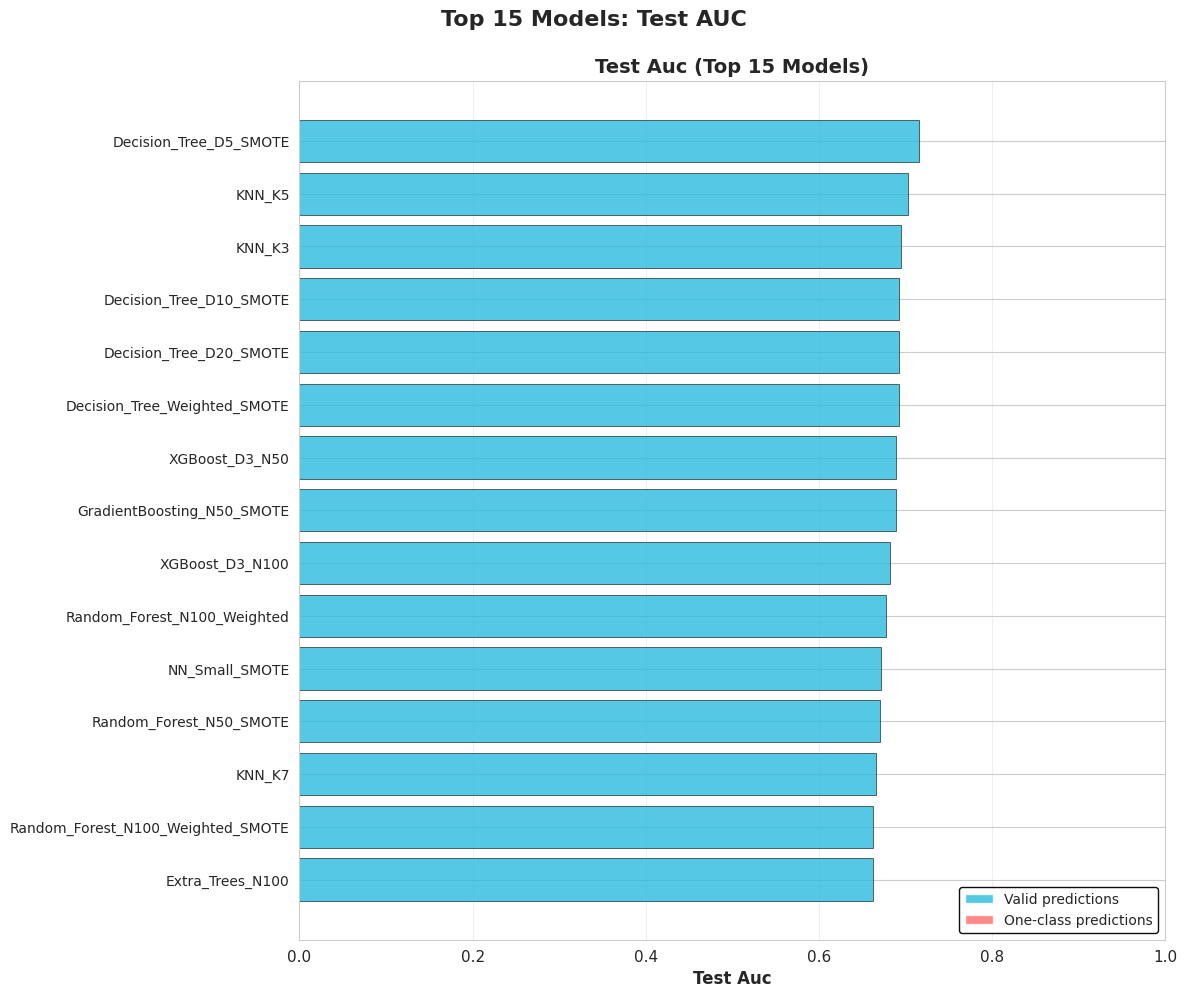

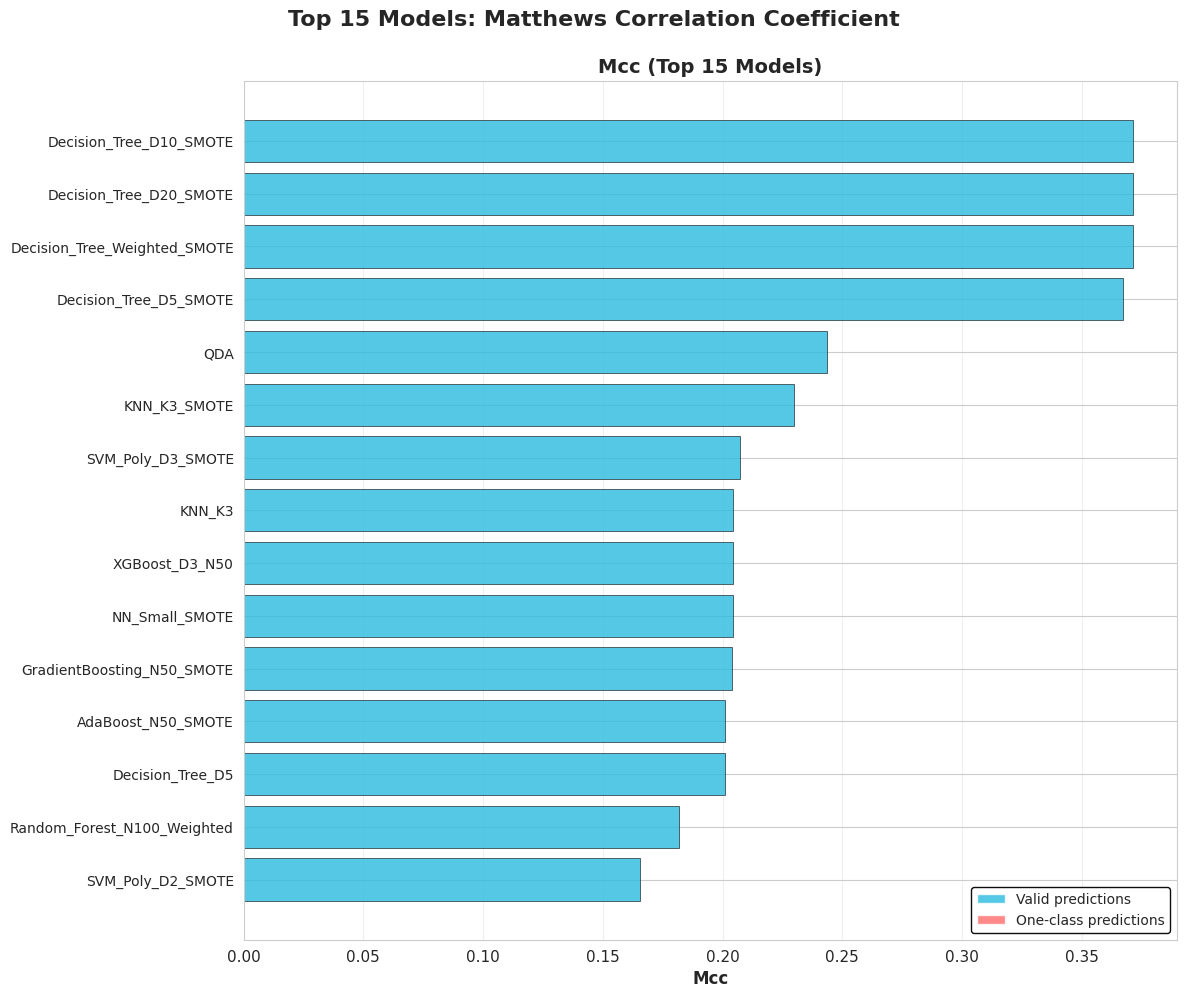

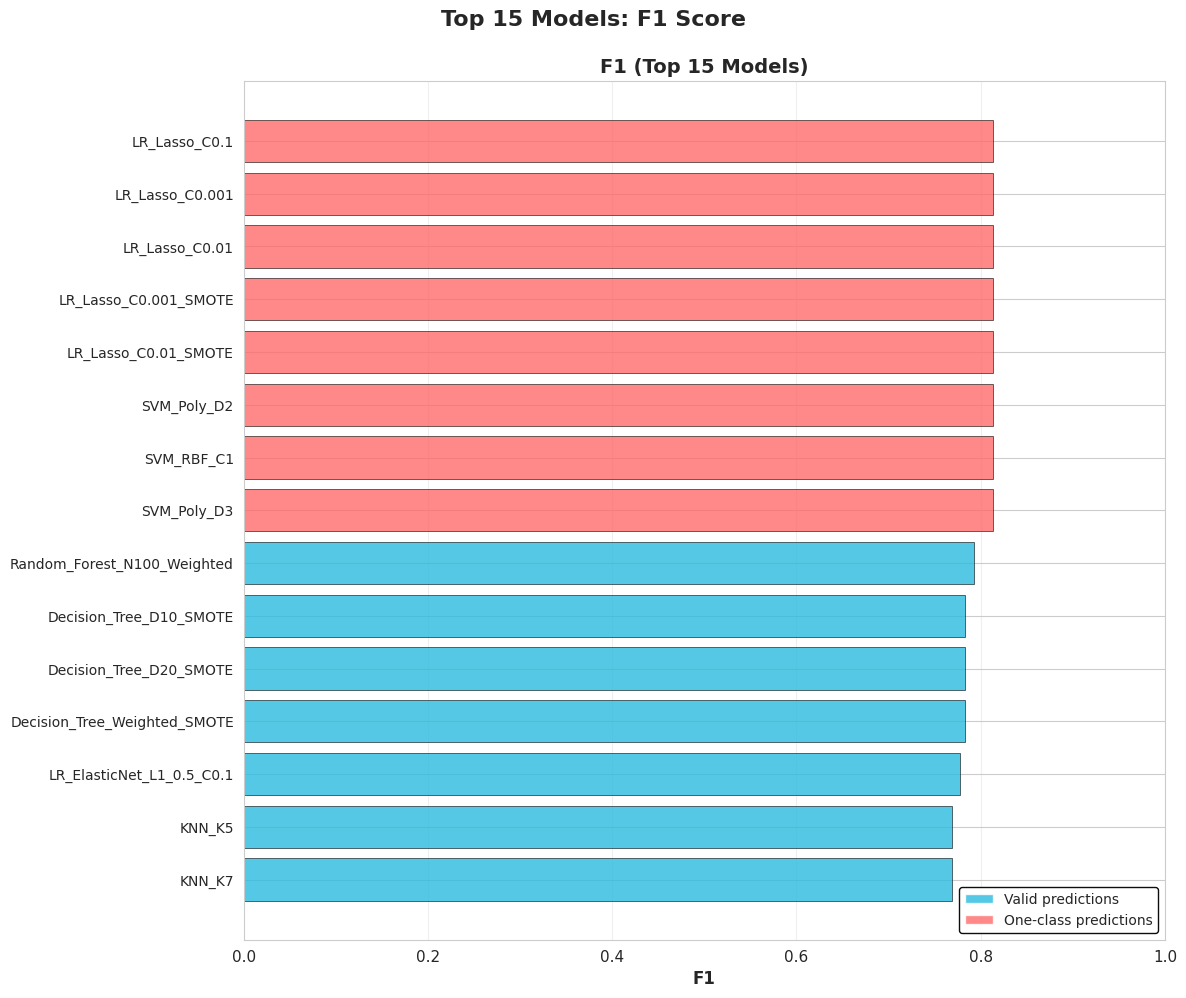

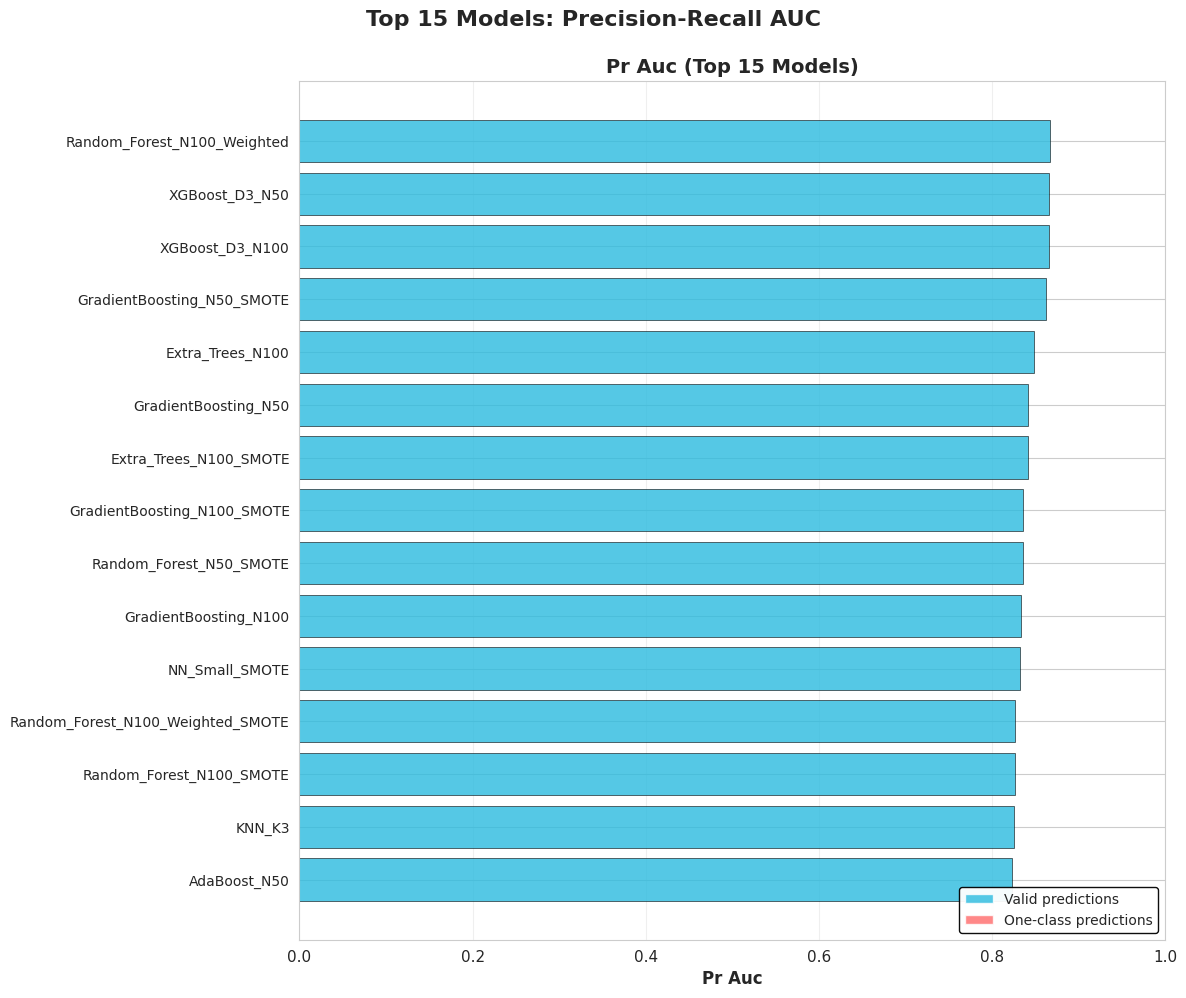

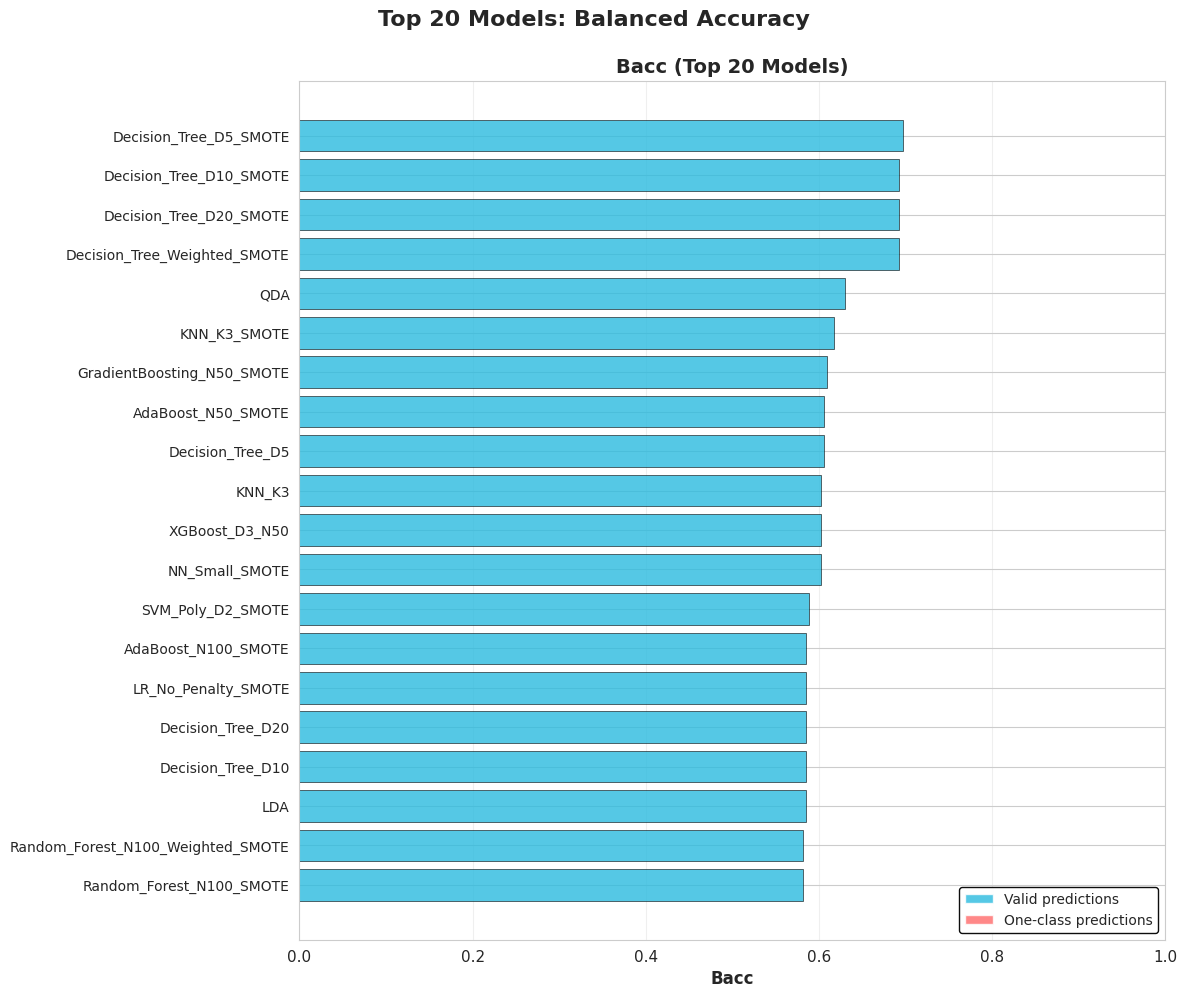

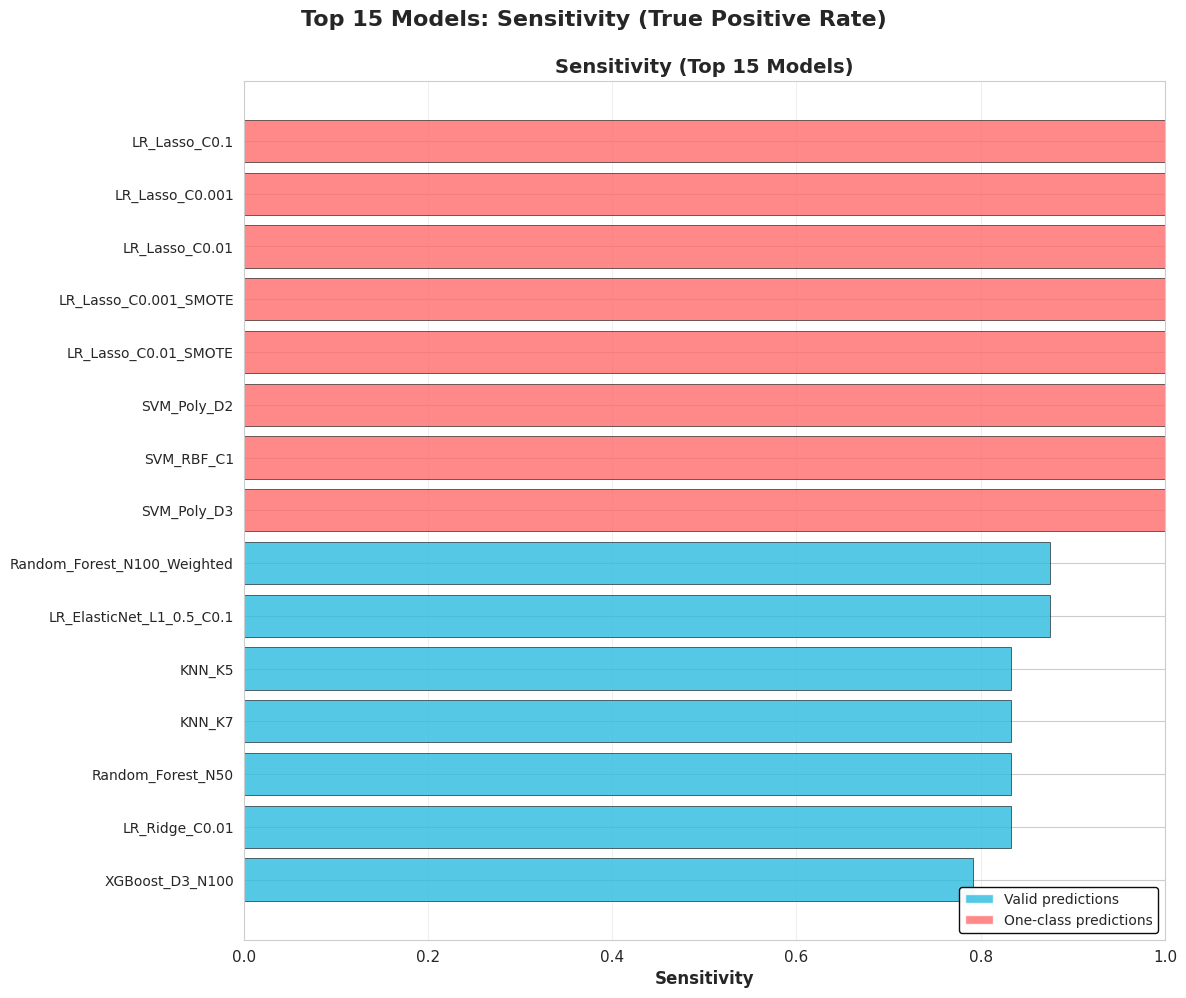

In [32]:
# Example 1: Test AUC
fig1 = plot_single_metric(results_combined_df, n=15, metric='test_auc',
                          title='Top 15 Models: Test AUC')
plt.savefig('fig_top15_test_auc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 2: MCC
fig2 = plot_single_metric(results_combined_df, n=15, metric='mcc',
                          title='Top 15 Models: Matthews Correlation Coefficient')
plt.savefig('fig_top15_mcc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 3: F1 Score
fig3 = plot_single_metric(results_combined_df, n=15, metric='f1',
                          title='Top 15 Models: F1 Score')
plt.savefig('fig_top15_f1.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 4: PR-AUC
fig4 = plot_single_metric(results_combined_df, n=15, metric='pr_auc',
                          title='Top 15 Models: Precision-Recall AUC')
plt.savefig('fig_top15_pr_auc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 5: Balanced Accuracy
fig5 = plot_single_metric(results_combined_df, n=20, metric='bacc',
                          title='Top 20 Models: Balanced Accuracy')
plt.savefig('fig_top20_bacc.png', dpi=300, bbox_inches='tight')
plt.show()

# Example 6: Sensitivity
fig6 = plot_single_metric(results_combined_df, n=15, metric='sensitivity',
                          title='Top 15 Models: Sensitivity (True Positive Rate)')
plt.savefig('fig_top15_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()


## With Confidence Intervals


✓ Saved: model_comparison_metrics.png


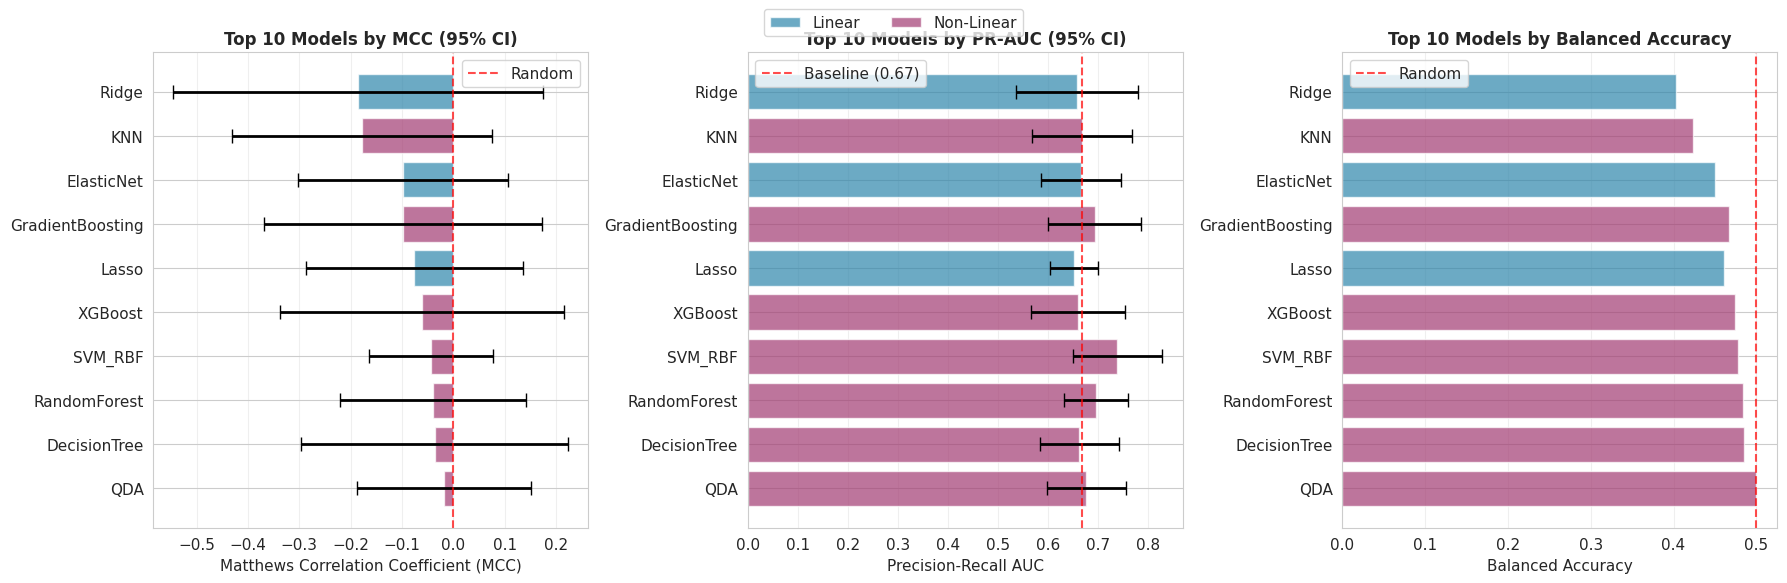

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

top_n = 10
top_models = comparison_df.head(top_n)

# MCC Plot
ax = axes[0]
y_pos = np.arange(len(top_models))
colors = ['#2E86AB' if t == 'Linear' else '#A23B72' for t in top_models['model_type']]

ax.barh(y_pos, top_models['mean_mcc'], color=colors, alpha=0.7)
ax.errorbar(top_models['mean_mcc'], y_pos, 
            xerr=[top_models['mean_mcc'] - top_models['ci_mcc_lower'],
                  top_models['ci_mcc_upper'] - top_models['mean_mcc']],
            fmt='none', color='black', capsize=5, linewidth=2)

ax.axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Random')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_models['model'])
ax.set_xlabel('Matthews Correlation Coefficient (MCC)', fontsize=11)
ax.set_title('Top 10 Models by MCC (95% CI)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# PR-AUC Plot
ax = axes[1]
ax.barh(y_pos, top_models['mean_pr_auc'], color=colors, alpha=0.7)
ax.errorbar(top_models['mean_pr_auc'], y_pos,
            xerr=[top_models['mean_pr_auc'] - top_models['ci_pr_auc_lower'],
                  top_models['ci_pr_auc_upper'] - top_models['mean_pr_auc']],
            fmt='none', color='black', capsize=5, linewidth=2)

baseline_pr = sum(y_train) / len(y_train)
ax.axvline(baseline_pr, color='red', linestyle='--', linewidth=1.5, alpha=0.7, 
           label=f'Baseline ({baseline_pr:.2f})')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_models['model'])
ax.set_xlabel('Precision-Recall AUC', fontsize=11)
ax.set_title('Top 10 Models by PR-AUC (95% CI)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Balanced Accuracy
ax = axes[2]
ax.barh(y_pos, top_models['mean_bacc'], color=colors, alpha=0.7)
ax.axvline(0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Random')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_models['model'])
ax.set_xlabel('Balanced Accuracy', fontsize=11)
ax.set_title('Top 10 Models by Balanced Accuracy', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86AB', alpha=0.7, label='Linear'),
                   Patch(facecolor='#A23B72', alpha=0.7, label='Non-Linear')]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: model_comparison_metrics.png")
plt.show()

## Interpretability and Trade-offs

✓ Saved: interpretability_performance_tradeoff.png


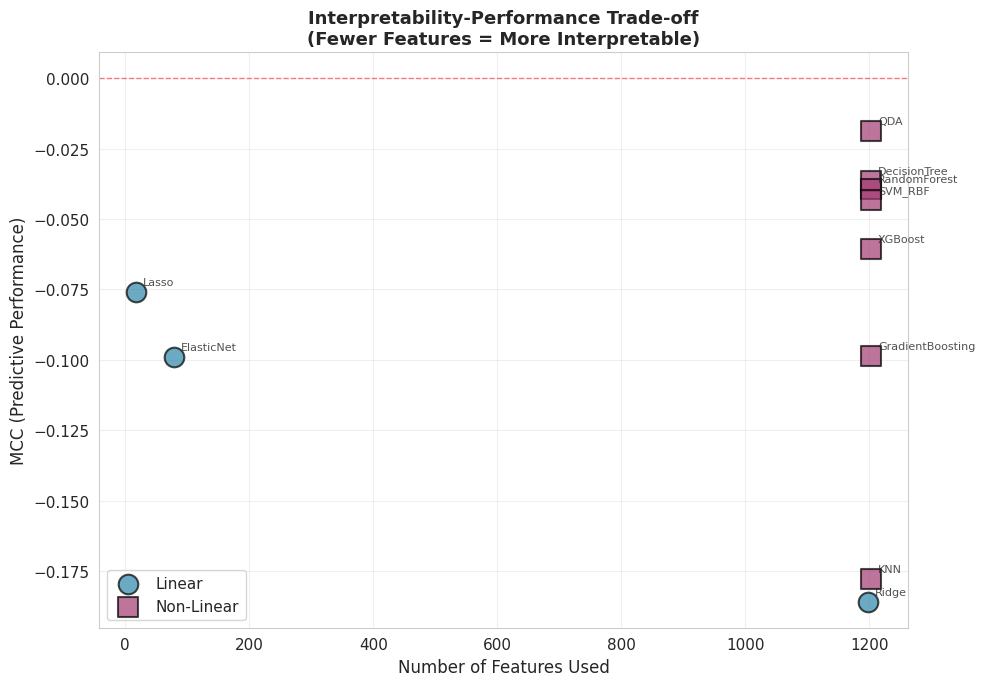

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))

linear_models = comparison_df[comparison_df['model_type'] == 'Linear']
nonlinear_models = comparison_df[comparison_df['model_type'] == 'Non-Linear']

ax.scatter(linear_models['mean_n_features'], linear_models['mean_mcc'], 
           s=200, alpha=0.7, color='#2E86AB', marker='o', 
           edgecolors='black', linewidth=1.5, label='Linear')

ax.scatter(nonlinear_models['mean_n_features'], nonlinear_models['mean_mcc'], 
           s=200, alpha=0.7, color='#A23B72', marker='s', 
           edgecolors='black', linewidth=1.5, label='Non-Linear')

for idx, row in comparison_df.head(15).iterrows():
    ax.annotate(row['model'], 
                (row['mean_n_features'], row['mean_mcc']),
                xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.8)

ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Number of Features Used', fontsize=12)
ax.set_ylabel('MCC (Predictive Performance)', fontsize=12)
ax.set_title('Interpretability-Performance Trade-off\n(Fewer Features = More Interpretable)', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('interpretability_performance_tradeoff.png', dpi=300, bbox_inches='tight')
print("✓ Saved: interpretability_performance_tradeoff.png")
plt.show()

## Sensitivity-Specificity Balanced

✓ Saved: sensitivity_specificity_balance.png


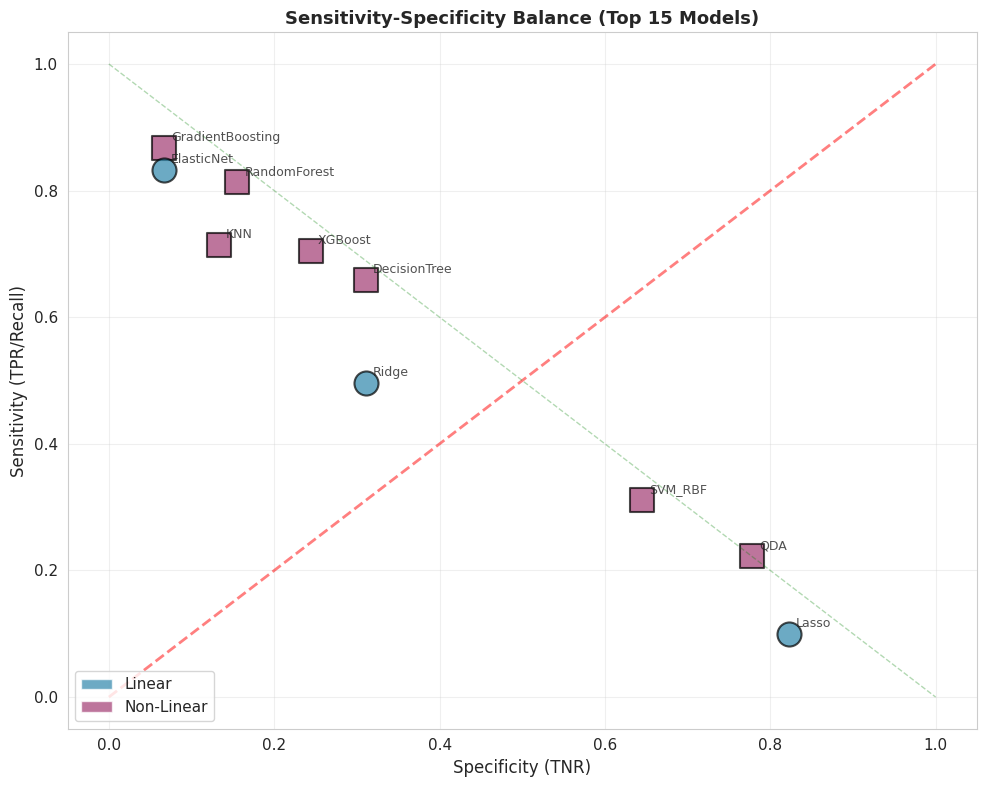

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))

for idx, row in comparison_df.head(15).iterrows():
    color = '#2E86AB' if row['model_type'] == 'Linear' else '#A23B72'
    marker = 'o' if row['model_type'] == 'Linear' else 's'
    
    ax.scatter(row['mean_specificity'], row['mean_sensitivity'], 
               s=300, alpha=0.7, color=color, marker=marker,
               edgecolors='black', linewidth=1.5)
    
    ax.annotate(row['model'], 
                (row['mean_specificity'], row['mean_sensitivity']),
                xytext=(5, 5), textcoords='offset points', 
                fontsize=9, alpha=0.8)

ax.plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.5, label='Random Classifier')
ax.plot([0, 1], [1, 0], 'g--', linewidth=1, alpha=0.3)

ax.set_xlabel('Specificity (TNR)', fontsize=12)
ax.set_ylabel('Sensitivity (TPR/Recall)', fontsize=12)
ax.set_title('Sensitivity-Specificity Balance (Top 15 Models)', 
             fontsize=13, fontweight='bold')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E86AB', alpha=0.7, label='Linear'),
    Patch(facecolor='#A23B72', alpha=0.7, label='Non-Linear')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=11)

plt.tight_layout()
plt.savefig('sensitivity_specificity_balance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: sensitivity_specificity_balance.png")
plt.show()


## Model Type Comparison

✓ Saved: model_type_comparison_boxplot.png


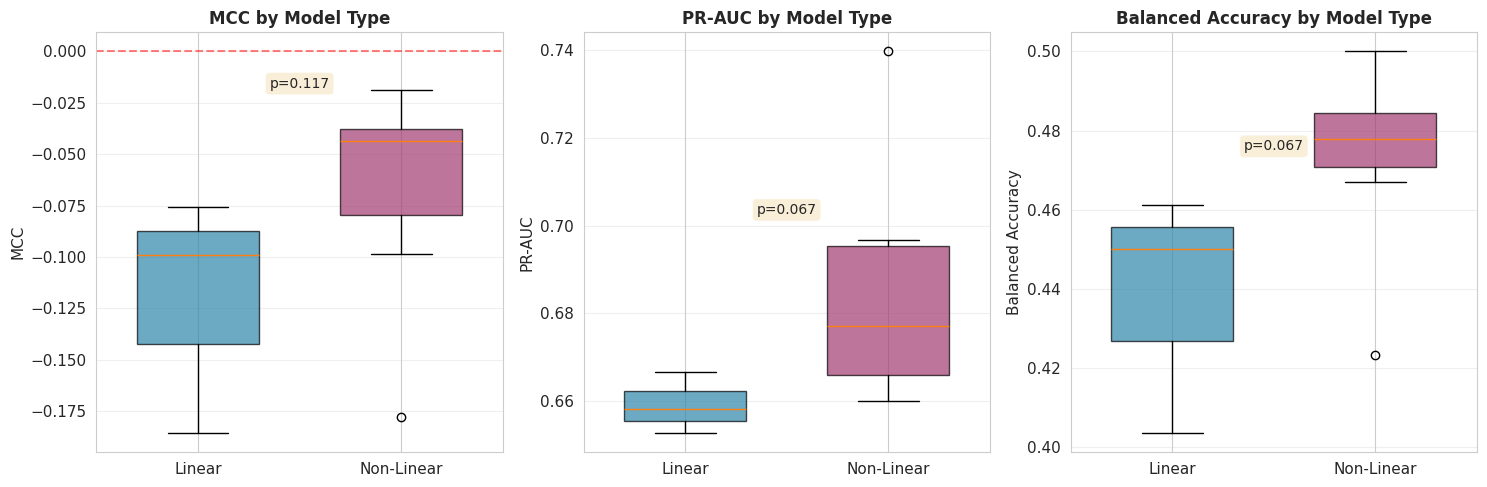

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = [
    ('mean_mcc', 'MCC'),
    ('mean_pr_auc', 'PR-AUC'),
    ('mean_bacc', 'Balanced Accuracy')
]

for idx, (metric, label) in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    data_to_plot = [
        comparison_df[comparison_df['model_type'] == 'Linear'][metric].values,
        comparison_df[comparison_df['model_type'] == 'Non-Linear'][metric].values
    ]
    
    bp = ax.boxplot(data_to_plot, labels=['Linear', 'Non-Linear'],
                    patch_artist=True, widths=0.6)
    
    colors = ['#2E86AB', '#A23B72']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    if metric == 'mean_mcc':
        ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    
    ax.set_ylabel(label, fontsize=11)
    ax.set_title(f'{label} by Model Type', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    linear_median = np.median(data_to_plot[0])
    nonlinear_median = np.median(data_to_plot[1])
    
    _, p_value = stats.mannwhitneyu(data_to_plot[0], data_to_plot[1], alternative='two-sided')
    
    y_max = max(np.max(data_to_plot[0]), np.max(data_to_plot[1]))
    ax.text(1.5, y_max * 0.95, f'p={p_value:.3f}', 
            ha='center', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('model_type_comparison_boxplot.png', dpi=300, bbox_inches='tight')
print("✓ Saved: model_type_comparison_boxplot.png")
plt.show()

## Train Best Linear Models with Stable Features (For Interpretability) 

In [38]:
print("\n" + "="*80)
print("STABILITY SELECTION ON BEST LINEAR MODEL")
print("="*80)

best_linear_name = best_linear['model']
print(f"Running stability selection on: {best_linear_name}")

if 'Lasso' in best_linear_name:
    penalty = 'l1'
    l1_ratio = None
elif 'ElasticNet' in best_linear_name:
    penalty = 'elasticnet'
    l1_ratio = 0.5
else:
    penalty = 'l2'
    l1_ratio = None

def stability_selection(X, y, penalty='l1', l1_ratio=0.5, n_bootstraps=100, 
                        threshold=0.7, C_range=None):
    n_samples, n_features = X.shape
    if C_range is None:
        C_range = np.logspace(-3, 2, 20)
    
    selection_matrix = np.zeros((n_bootstraps, n_features))
    
    for b in range(n_bootstraps):
        sample_idx = resample(np.arange(n_samples), n_samples=n_samples//2, 
                              replace=False, random_state=b)
        X_boot = X[sample_idx]
        y_boot = y.iloc[sample_idx]
        
        for C in C_range:
            if penalty == 'l1':
                model = LogisticRegression(penalty='l1', C=C, solver='liblinear', 
                                          max_iter=10000, random_state=b)
            elif penalty == 'elasticnet':
                model = LogisticRegression(penalty='elasticnet', C=C, 
                                          l1_ratio=l1_ratio, solver='saga', 
                                          max_iter=10000, random_state=b)
            elif penalty == 'l2':
                model = LogisticRegression(penalty='l2', C=C, solver='lbfgs',
                                          max_iter=10000, random_state=b)
            
            model.fit(X_boot, y_boot)
            selected = np.abs(model.coef_[0]) > 1e-5
            selection_matrix[b, :] = np.maximum(selection_matrix[b, :], selected)
    
    selection_freq = selection_matrix.mean(axis=0)
    stable_features = np.where(selection_freq >= threshold)[0]
    
    return selection_freq, stable_features

selection_freq, stable_features = stability_selection(
    X_train_scaled, y_train, 
    penalty=penalty, l1_ratio=l1_ratio,
    n_bootstraps=100, threshold=0.7
)

print(f"\nStable features (π≥0.7): {len(stable_features)}")
print(f"Mean selection frequency: {selection_freq[stable_features].mean():.3f}")


STABILITY SELECTION ON BEST LINEAR MODEL
Running stability selection on: Lasso

Stable features (π≥0.7): 2
Mean selection frequency: 0.725


## SMOTE vs No-SMOTE

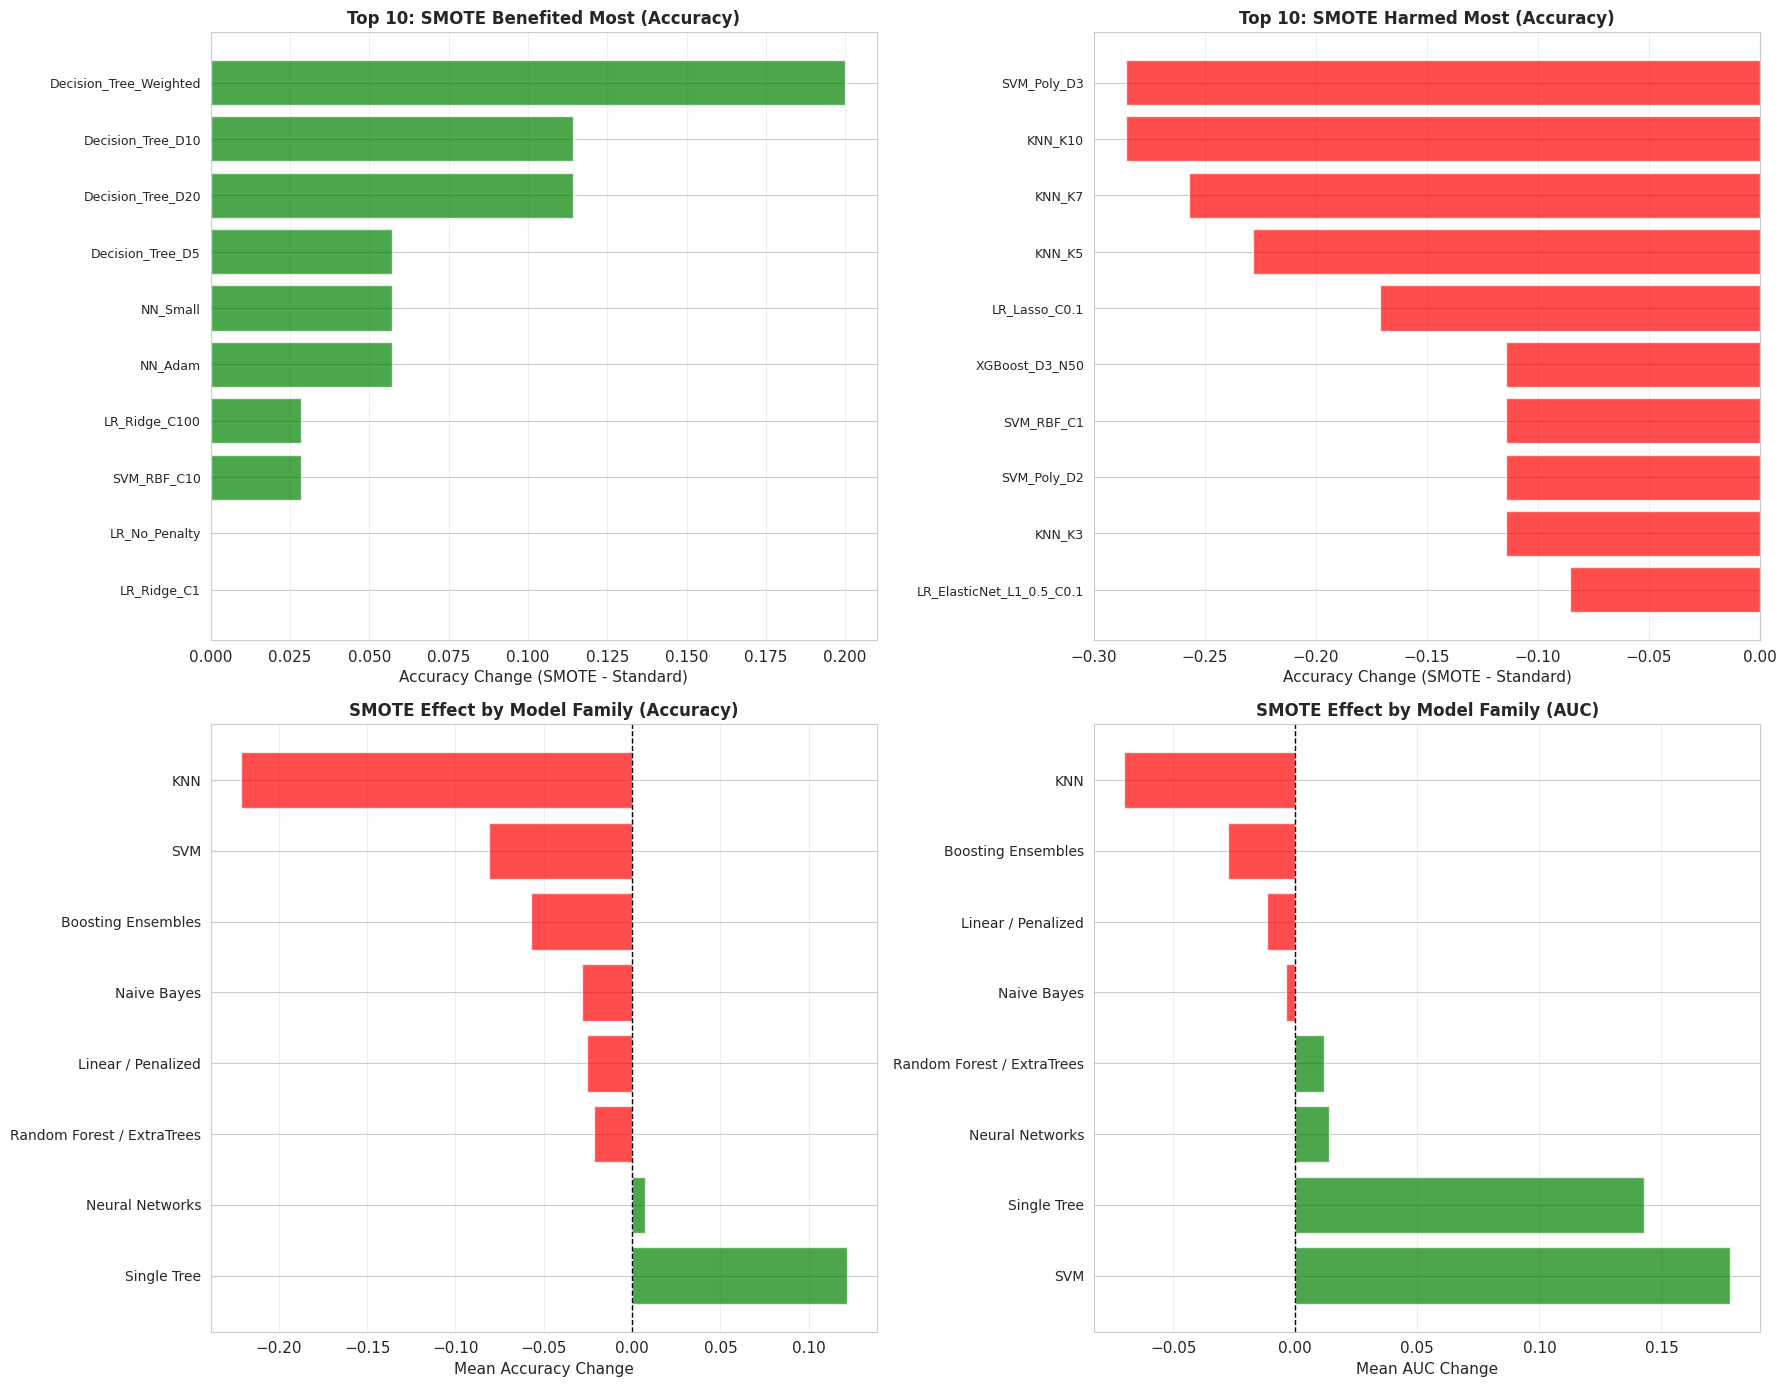


SMOTE IMPACT ANALYSIS

Top 5 Models Benefited (Accuracy):
                 Model  Delta_Acc  Pct_Change_Acc  Delta_AUC
Decision_Tree_Weighted   0.200000       38.888889   0.219697
     Decision_Tree_D10   0.114286       19.047619   0.107955
     Decision_Tree_D20   0.114286       19.047619   0.107955
      Decision_Tree_D5   0.057143        9.090909   0.136364
              NN_Small   0.057143        9.523810   0.022727

Top 5 Models Harmed (Accuracy):
        Model  Delta_Acc  Pct_Change_Acc  Delta_AUC
  SVM_Poly_D3  -0.285714      -41.666667   0.208333
      KNN_K10  -0.285714      -43.478261  -0.051136
       KNN_K7  -0.257143      -39.130435  -0.043561
       KNN_K5  -0.228571      -34.782609  -0.136364
LR_Lasso_C0.1  -0.171429      -25.000000  -0.045455

Group-Level Summary:
                           Delta_Acc         Delta_AUC        
                                mean     std      mean     std
Group                                                         
Boosting Ensembles 

In [39]:
def quantify_smote_effect(models_dict, X_train, X_train_smote, X_test, 
                         y_train, y_train_smote, y_test):
    """
    Systematic comparison of SMOTE vs standard training
    Key finding for Objective 3: Model-dependent SMOTE efficacy
    """
    smote_comparison = []
    
    for model_name, model in models_dict.items():
        # Skip models that don't work with SMOTE
        if any(x in model_name for x in ['LDA', 'QDA', 'SMOTE']):
            continue
        
        # Standard training
        model_standard = clone(model)
        model_standard.fit(X_train, y_train)
        y_pred_standard = model_standard.predict(X_test)
        y_proba_standard = model_standard.predict_proba(X_test)[:, 1] if hasattr(model_standard, 'predict_proba') else y_pred_standard
        
        acc_standard = accuracy_score(y_test, y_pred_standard)
        auc_standard = roc_auc_score(y_test, y_proba_standard)
        
        # SMOTE training
        model_smote = clone(model)
        model_smote.fit(X_train_smote, y_train_smote)
        y_pred_smote = model_smote.predict(X_test)
        y_proba_smote = model_smote.predict_proba(X_test)[:, 1] if hasattr(model_smote, 'predict_proba') else y_pred_smote
        
        acc_smote = accuracy_score(y_test, y_pred_smote)
        auc_smote = roc_auc_score(y_test, y_proba_smote)
        
        # Calculate deltas
        delta_acc = acc_smote - acc_standard
        delta_auc = auc_smote - auc_standard
        pct_change_acc = (delta_acc / acc_standard) * 100
        pct_change_auc = (delta_auc / auc_standard) * 100 if auc_standard > 0 else 0
        
        smote_comparison.append({
            'Model': model_name,
            'Group': assign_model_group(model_name),
            'Standard_Acc': acc_standard,
            'SMOTE_Acc': acc_smote,
            'Delta_Acc': delta_acc,
            'Pct_Change_Acc': pct_change_acc,
            'Standard_AUC': auc_standard,
            'SMOTE_AUC': auc_smote,
            'Delta_AUC': delta_auc,
            'Pct_Change_AUC': pct_change_auc
        })
    
    smote_df = pd.DataFrame(smote_comparison)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Top 10 benefited (by accuracy)
    top_benefit = smote_df.nlargest(10, 'Delta_Acc')
    axes[0, 0].barh(range(len(top_benefit)), top_benefit['Delta_Acc'], color='green', alpha=0.7)
    axes[0, 0].set_yticks(range(len(top_benefit)))
    axes[0, 0].set_yticklabels(top_benefit['Model'], fontsize=9)
    axes[0, 0].set_xlabel('Accuracy Change (SMOTE - Standard)', fontsize=11)
    axes[0, 0].set_title('Top 10: SMOTE Benefited Most (Accuracy)', fontsize=12, weight='bold')
    axes[0, 0].grid(axis='x', alpha=0.3)
    axes[0, 0].invert_yaxis()
    
    # Top 10 harmed (by accuracy)
    top_harm = smote_df.nsmallest(10, 'Delta_Acc')
    axes[0, 1].barh(range(len(top_harm)), top_harm['Delta_Acc'], color='red', alpha=0.7)
    axes[0, 1].set_yticks(range(len(top_harm)))
    axes[0, 1].set_yticklabels(top_harm['Model'], fontsize=9)
    axes[0, 1].set_xlabel('Accuracy Change (SMOTE - Standard)', fontsize=11)
    axes[0, 1].set_title('Top 10: SMOTE Harmed Most (Accuracy)', fontsize=12, weight='bold')
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].invert_yaxis()
    
    # Group-level effects (Accuracy)
    group_effects_acc = smote_df.groupby('Group')['Delta_Acc'].mean().sort_values()
    colors_group = ['green' if x > 0 else 'red' for x in group_effects_acc]
    axes[1, 0].barh(range(len(group_effects_acc)), group_effects_acc, color=colors_group, alpha=0.7)
    axes[1, 0].set_yticks(range(len(group_effects_acc)))
    axes[1, 0].set_yticklabels(group_effects_acc.index, fontsize=10)
    axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=1)
    axes[1, 0].set_xlabel('Mean Accuracy Change', fontsize=11)
    axes[1, 0].set_title('SMOTE Effect by Model Family (Accuracy)', fontsize=12, weight='bold')
    axes[1, 0].grid(axis='x', alpha=0.3)
    axes[1, 0].invert_yaxis()
    
    # Group-level effects (AUC)
    group_effects_auc = smote_df.groupby('Group')['Delta_AUC'].mean().sort_values()
    colors_group_auc = ['green' if x > 0 else 'red' for x in group_effects_auc]
    axes[1, 1].barh(range(len(group_effects_auc)), group_effects_auc, color=colors_group_auc, alpha=0.7)
    axes[1, 1].set_yticks(range(len(group_effects_auc)))
    axes[1, 1].set_yticklabels(group_effects_auc.index, fontsize=10)
    axes[1, 1].axvline(0, color='black', linestyle='--', linewidth=1)
    axes[1, 1].set_xlabel('Mean AUC Change', fontsize=11)
    axes[1, 1].set_title('SMOTE Effect by Model Family (AUC)', fontsize=12, weight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
    axes[1, 1].invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('fig_smote_comprehensive_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "="*80)
    print("SMOTE IMPACT ANALYSIS")
    print("="*80)
    print("\nTop 5 Models Benefited (Accuracy):")
    print(smote_df.nlargest(5, 'Delta_Acc')[['Model', 'Delta_Acc', 'Pct_Change_Acc', 'Delta_AUC']].to_string(index=False))
    
    print("\nTop 5 Models Harmed (Accuracy):")
    print(smote_df.nsmallest(5, 'Delta_Acc')[['Model', 'Delta_Acc', 'Pct_Change_Acc', 'Delta_AUC']].to_string(index=False))
    
    print("\nGroup-Level Summary:")
    group_summary = smote_df.groupby('Group').agg({
        'Delta_Acc': ['mean', 'std'],
        'Delta_AUC': ['mean', 'std']
    }).round(4)
    print(group_summary)
    
    # Save results
    smote_df.to_csv('smote_impact_analysis.csv', index=False)
    print("\n✓ SMOTE analysis exported to 'smote_impact_analysis.csv'")
    
    return smote_df

# Execute
from sklearn.base import clone
smote_impact_df = quantify_smote_effect(models, X_train_scaled, X_train_smote, 
                                        X_test_scaled, y_train, y_train_smote, y_test)


## Group Performance Boxplot

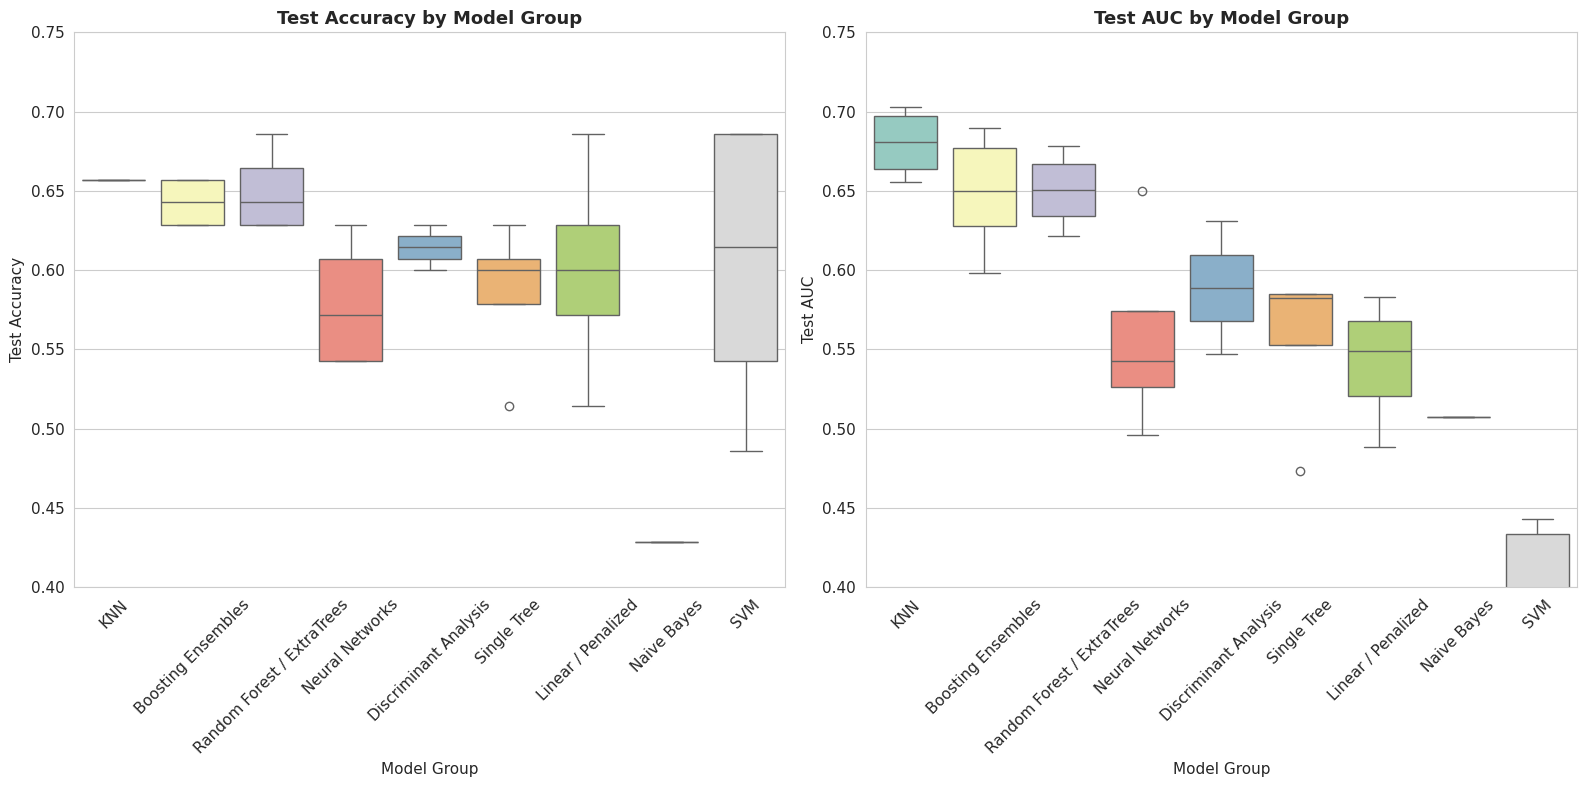

In [40]:
def plot_grouped_performance(results_df):
    """Boxplot by model group"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Filter out SMOTE variants for clearer comparison
    df_no_smote = results_df[~results_df['model'].str.contains('SMOTE')]
    
    sns.boxplot(data=df_no_smote, x='Group', y='test_acc', 
               palette='Set3', ax=axes[0])
    axes[0].set_xlabel('Model Group', fontsize=11)
    axes[0].set_ylabel('Test Accuracy', fontsize=11)
    axes[0].set_title('Test Accuracy by Model Group', fontsize=13, weight='bold')
    axes[0].set_ylim(0.4, 0.75)
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.boxplot(data=df_no_smote, x='Group', y='test_auc', 
               palette='Set3', ax=axes[1])
    axes[1].set_xlabel('Model Group', fontsize=11)
    axes[1].set_ylabel('Test AUC', fontsize=11)
    axes[1].set_title('Test AUC by Model Group', fontsize=13, weight='bold')
    axes[1].set_ylim(0.4, 0.75)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('fig_group_performance_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_grouped_performance(results_combined_df)


## Train vs Test Accuracy Scatter


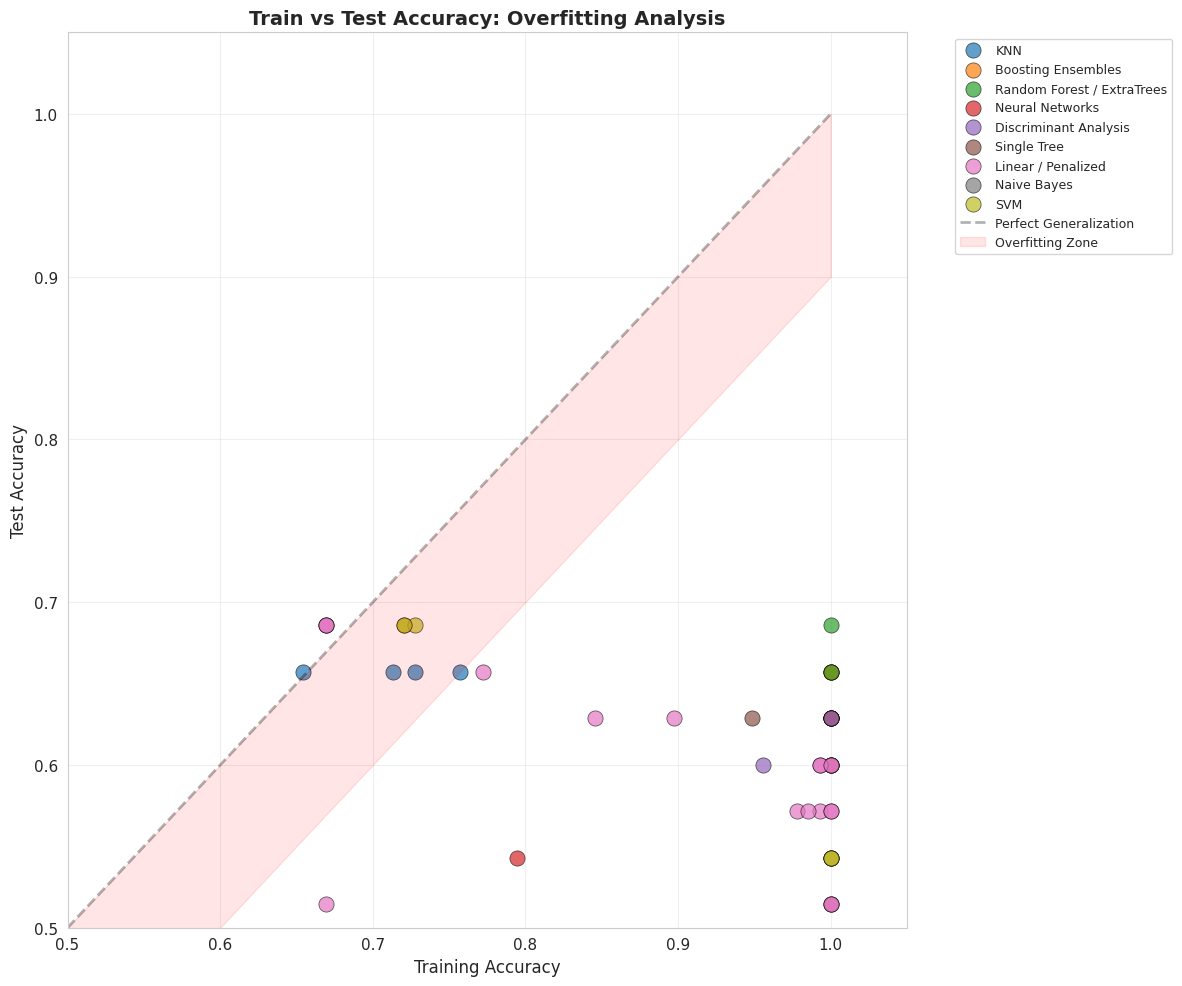


OVERFITTING ANALYSIS

Top 5 worst overfitters:
                 model  train_acc  test_acc  overfitting_gap
           SVM_RBF_C10        1.0  0.485714         0.514286
         LR_Ridge_C100        1.0  0.514286         0.485714
      Ridge_Classifier        1.0  0.514286         0.485714
Decision_Tree_Weighted        1.0  0.514286         0.485714
          LR_Ridge_C10        1.0  0.542857         0.457143

Top 5 best generalizers:
          model  train_acc  test_acc  overfitting_gap
  LR_Lasso_C0.1   0.669118  0.685714        -0.016597
LR_Lasso_C0.001   0.669118  0.685714        -0.016597
 LR_Lasso_C0.01   0.669118  0.685714        -0.016597
        KNN_K10   0.654412  0.657143        -0.002731
    SVM_Poly_D2   0.720588  0.685714         0.034874


In [41]:
def plot_train_test_scatter_enhanced(results_df):
    """Enhanced train vs test scatter with overfitting zones"""
    df_plot = results_df[~results_df['model'].str.contains('SMOTE')].copy()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Color by group
    groups = df_plot['Group'].unique()
    palette = sns.color_palette('tab10', n_colors=len(groups))
    color_map = dict(zip(groups, palette))
    
    for group in groups:
        group_data = df_plot[df_plot['Group'] == group]
        ax.scatter(group_data['train_acc'], group_data['test_acc'],
                  label=group, s=120, alpha=0.7, 
                  color=color_map[group], edgecolors='black', linewidth=0.5)
    
    # Reference lines
    ax.plot([0.5, 1], [0.5, 1], 'k--', alpha=0.3, linewidth=2, 
            label='Perfect Generalization')
    
    # Overfitting zones
    ax.fill_between([0.5, 1], [0.4, 0.9], [0.5, 1], 
                    alpha=0.1, color='red', label='Overfitting Zone')
    
    ax.set_xlabel('Training Accuracy', fontsize=12)
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_title('Train vs Test Accuracy: Overfitting Analysis', 
                fontsize=14, weight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.set_xlim(0.5, 1.05)
    ax.set_ylim(0.5, 1.05)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fig_train_test_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print overfitting summary
    df_plot['overfitting_gap'] = df_plot['train_acc'] - df_plot['test_acc']
    print("\n" + "="*80)
    print("OVERFITTING ANALYSIS")
    print("="*80)
    print("\nTop 5 worst overfitters:")
    print(df_plot.nlargest(5, 'overfitting_gap')[
        ['model', 'train_acc', 'test_acc', 'overfitting_gap']
    ].to_string(index=False))
    
    print("\nTop 5 best generalizers:")
    print(df_plot.nsmallest(5, 'overfitting_gap')[
        ['model', 'train_acc', 'test_acc', 'overfitting_gap']
    ].to_string(index=False))

plot_train_test_scatter_enhanced(results_combined_df)


## Deceptively High-Performing Models Analysis

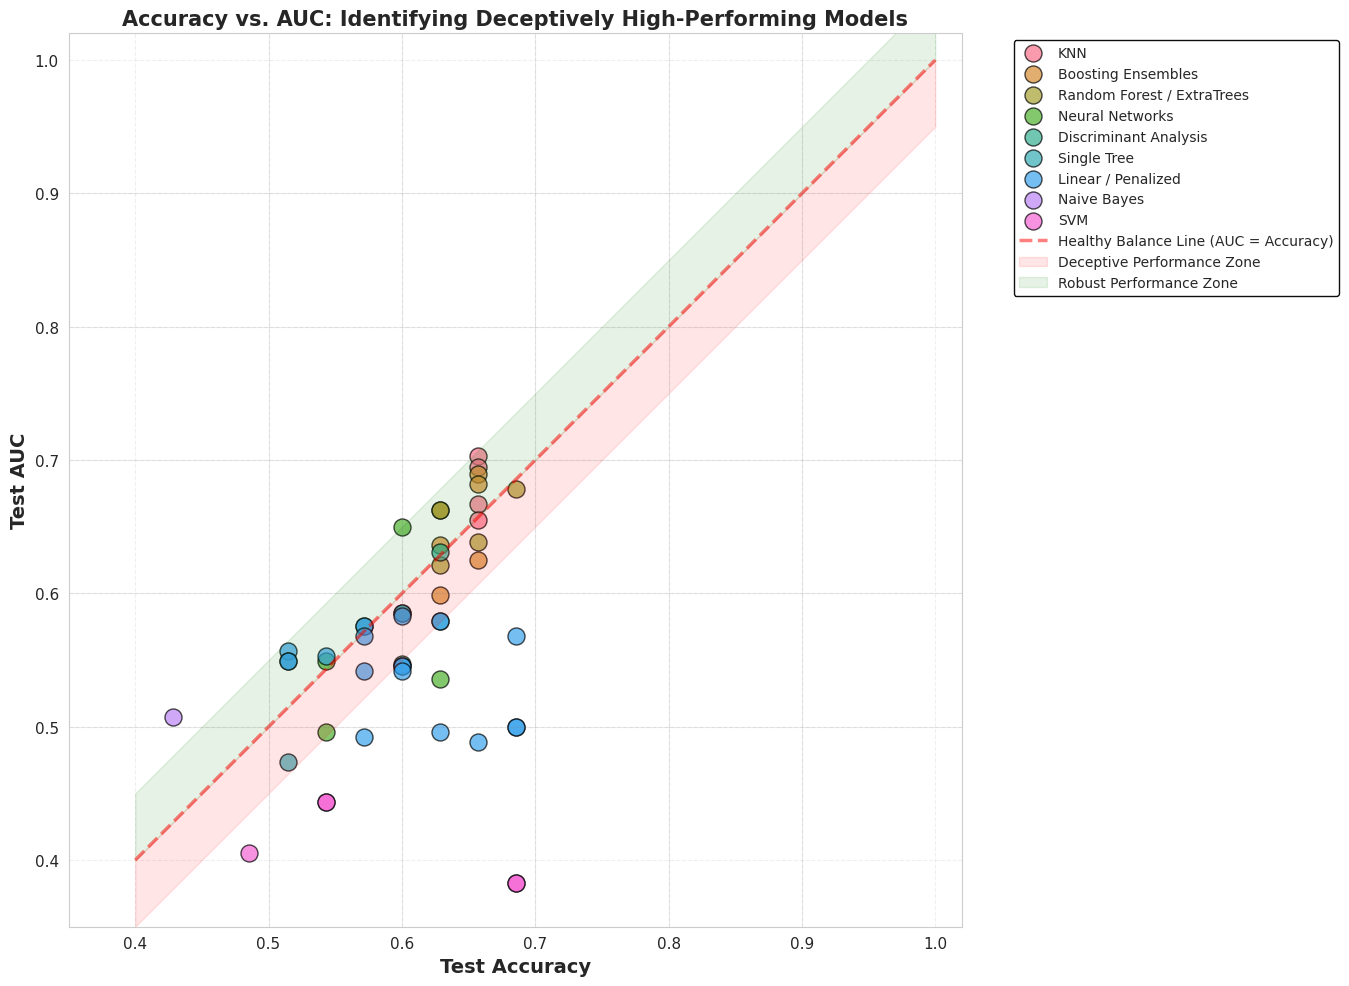


DECEPTIVELY HIGH-PERFORMING MODELS ANALYSIS

Models with High Accuracy but Low AUC (Accuracy - AUC > 0.02):
These models may be benefiting from class imbalance or other biases

                    model  test_acc  test_auc      gap                 Group
              SVM_Poly_D3  0.685714  0.333333 0.352381                   SVM
              SVM_Poly_D2  0.685714  0.382576 0.303139                   SVM
               SVM_RBF_C1  0.685714  0.382576 0.303139                   SVM
          LR_Lasso_C0.001  0.685714  0.500000 0.185714    Linear / Penalized
           LR_Lasso_C0.01  0.685714  0.500000 0.185714    Linear / Penalized
LR_ElasticNet_L1_0.5_C0.1  0.657143  0.488636 0.168506    Linear / Penalized
LR_ElasticNet_L1_0.3_C0.1  0.628571  0.496212 0.132359    Linear / Penalized
            LR_Lasso_C0.1  0.685714  0.568182 0.117532    Linear / Penalized
               SVM_Linear  0.542857  0.443182 0.099675                   SVM
      SVM_Linear_Weighted  0.542857  0.443182 0.0996

In [42]:
def plot_accuracy_vs_auc_threshold(results_df):
    """
    Scatter plot: Accuracy vs AUC with diagonal threshold line
    Models below the diagonal are "deceptively high-performing"
    (High accuracy but low AUC - likely due to class imbalance issues)
    """
    df_plot = results_df[~results_df['model'].str.contains('SMOTE')].copy()
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Color by group
    groups = df_plot['Group'].unique()
    palette = sns.color_palette('husl', n_colors=len(groups))
    color_map = dict(zip(groups, palette))
    
    # Plot each group
    for group in groups:
        group_data = df_plot[df_plot['Group'] == group]
        ax.scatter(group_data['test_acc'], group_data['test_auc'],
                  label=group, s=150, alpha=0.7, 
                  color=color_map[group], edgecolors='black', linewidth=1)
    
    # Diagonal threshold line (y = x)
    # Models above this line have AUC >= Accuracy (healthy balance)
    # Models below have AUC < Accuracy (deceptively high accuracy)
    ax.plot([0.4, 1.0], [0.4, 1.0], 'r--', alpha=0.5, linewidth=2.5,
            label='Healthy Balance Line (AUC = Accuracy)')
    
    # Deceptive zone (below the line)
    ax.fill_between([0.4, 1.0], [0.4, 1.0], [0.35, 0.95],
                    alpha=0.1, color='red', label='Deceptive Performance Zone')
    
    # Optimal zone (above the line)
    ax.fill_between([0.4, 1.0], [0.4, 1.0], [0.45, 1.05],
                    alpha=0.1, color='green', label='Robust Performance Zone')
    
    ax.set_xlabel('Test Accuracy', fontsize=14, weight='bold')
    ax.set_ylabel('Test AUC', fontsize=14, weight='bold')
    ax.set_title('Accuracy vs. AUC: Identifying Deceptively High-Performing Models',
                fontsize=15, weight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, 
             framealpha=0.95, edgecolor='black')
    ax.set_xlim(0.35, 1.02)
    ax.set_ylim(0.35, 1.02)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Add reference lines at 0.5 increments
    for val in [0.5, 0.6, 0.7, 0.8, 0.9]:
        ax.axhline(val, color='gray', alpha=0.15, linewidth=0.8)
        ax.axvline(val, color='gray', alpha=0.15, linewidth=0.8)
    
    # Make it square aspect
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.savefig('fig_accuracy_vs_auc_threshold.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analysis of deceptive models
    df_plot['gap'] = df_plot['test_acc'] - df_plot['test_auc']
    deceptive = df_plot[df_plot['gap'] > 0.02].sort_values('gap', ascending=False)
    
    print("\n" + "="*80)
    print("DECEPTIVELY HIGH-PERFORMING MODELS ANALYSIS")
    print("="*80)
    print("\nModels with High Accuracy but Low AUC (Accuracy - AUC > 0.02):")
    print("These models may be benefiting from class imbalance or other biases\n")
    
    if len(deceptive) > 0:
        print(deceptive[['model', 'test_acc', 'test_auc', 'gap', 'Group']].to_string(index=False))
        print(f"\nTotal deceptive models: {len(deceptive)}/{len(df_plot)}")
        print(f"Average gap for deceptive models: {deceptive['gap'].mean():.4f}")
    else:
        print("No deceptive models found (all models have AUC ≥ Accuracy - 0.02)")
    
    # Robust models
    robust = df_plot[df_plot['gap'] <= 0.02].sort_values('test_auc', ascending=False)
    print("\n" + "="*80)
    print("ROBUST MODELS (AUC ≥ Accuracy - 0.02):")
    print("="*80)
    print(f"Count: {len(robust)}/{len(df_plot)} models\n")
    print(robust[['model', 'test_acc', 'test_auc', 'gap', 'Group']].head(10).to_string(index=False))
    
    return deceptive, robust

deceptive_models, robust_models = plot_accuracy_vs_auc_threshold(results_combined_df)


Compare LR_Lasso_C0.1 (high accuracy, low AUC) vs. KNN_K5 (balanced metrics):

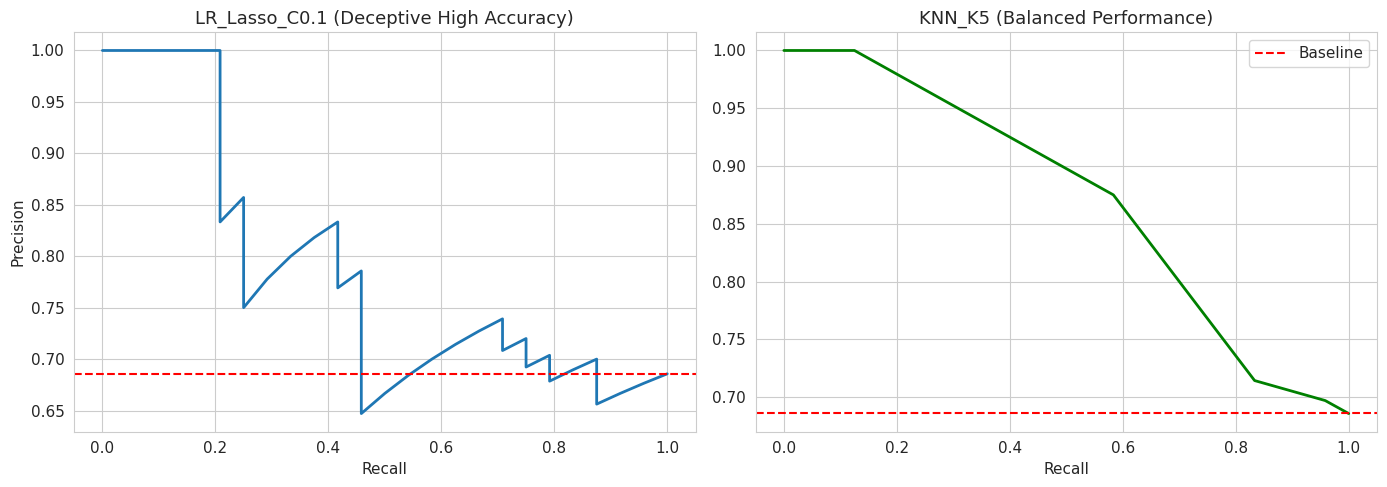

In [43]:
# Add this analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model 1: LR_Lasso_C0.1
model1 = models['LR_Lasso_C0.1']
model1.fit(X_train_scaled, y_train)
y_proba1 = model1.predict_proba(X_test_scaled)[:, 1]
precision1, recall1, _ = precision_recall_curve(y_test, y_proba1)

axes[0].plot(recall1, precision1, linewidth=2)
axes[0].set_title('LR_Lasso_C0.1 (Deceptive High Accuracy)', fontsize=13)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].axhline(y=0.686, color='red', linestyle='--', label='Baseline (prevalence)')

# Model 2: KNN_K5
model2 = models['KNN_K5']
model2.fit(X_train_scaled, y_train)
y_proba2 = model2.predict_proba(X_test_scaled)[:, 1]
precision2, recall2, _ = precision_recall_curve(y_test, y_proba2)

axes[1].plot(recall2, precision2, linewidth=2, color='green')
axes[1].set_title('KNN_K5 (Balanced Performance)', fontsize=13)
axes[1].set_xlabel('Recall')
axes[1].axhline(y=0.686, color='red', linestyle='--', label='Baseline')
axes[1].legend()

plt.tight_layout()
plt.savefig('precision_recall_comparison_deceptive_vs_balanced.png', dpi=300)
plt.show()


Demonstrate that small sample size (n=136) is the fundamental bottleneck

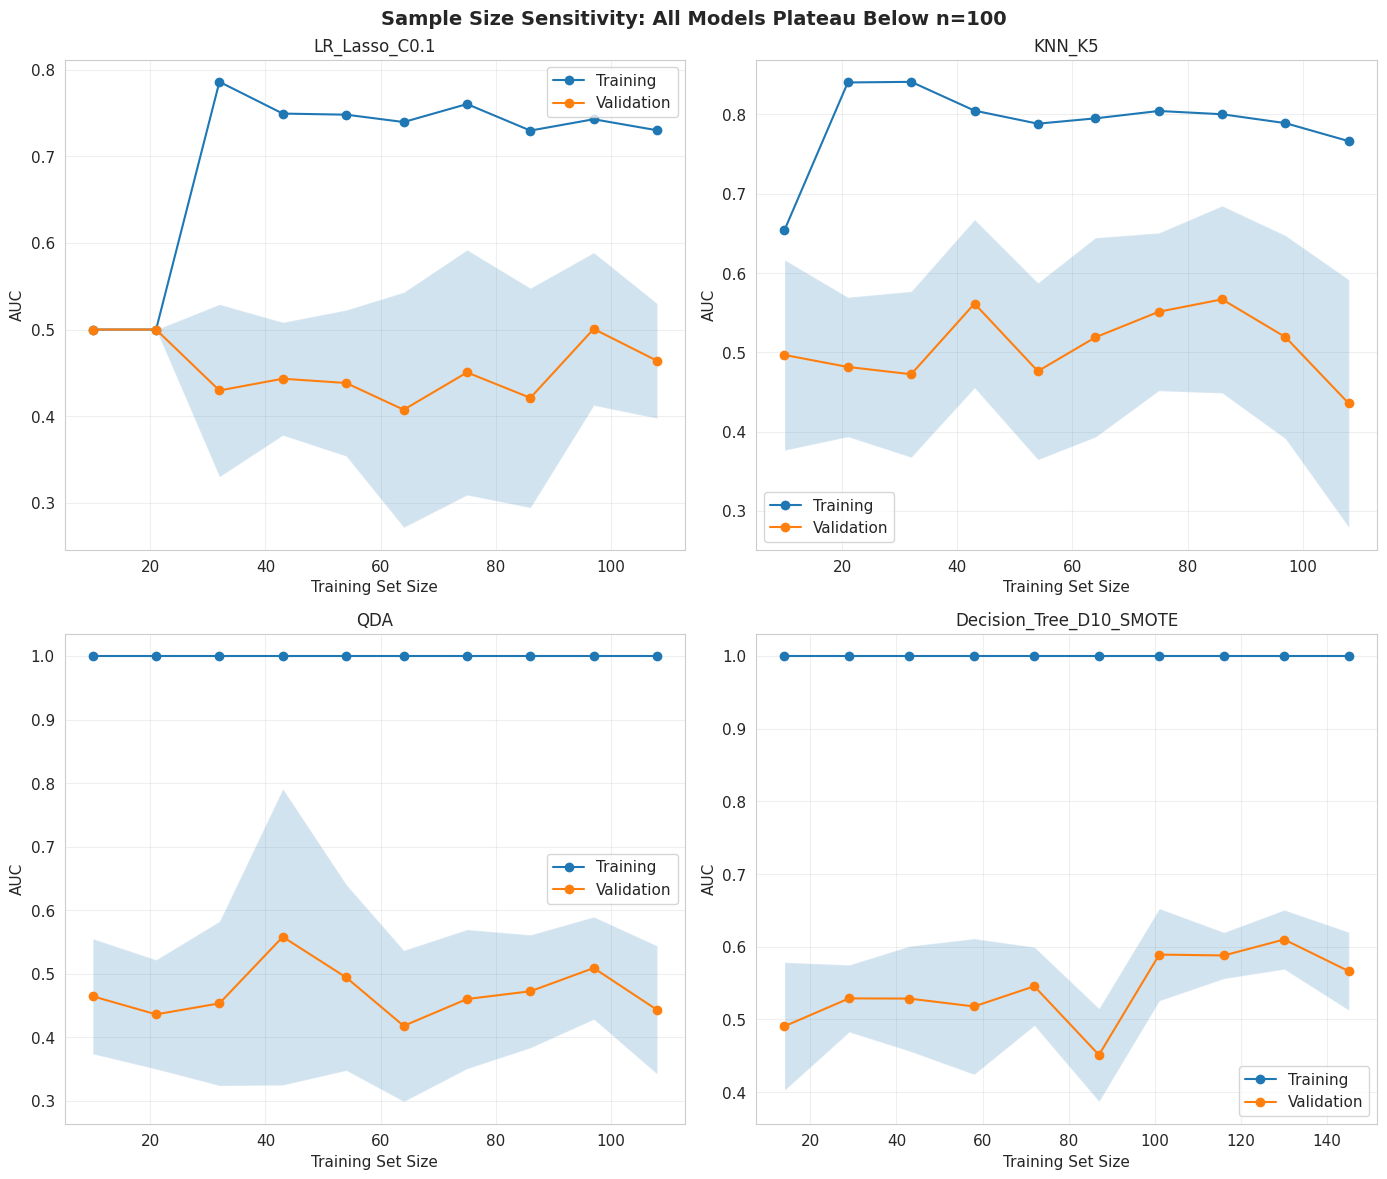

In [44]:
# Show how all models plateau early
from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
models_to_test = {
    'LR_Lasso_C0.1': models['LR_Lasso_C0.1'],
    'KNN_K5': models['KNN_K5'],
    'QDA': models['QDA'],
    'Decision_Tree_D10_SMOTE': models['Decision_Tree_D10']
}

for idx, (name, model) in enumerate(models_to_test.items()):
    ax = axes[idx // 2, idx % 2]
    
    # Use SMOTE data for decision tree
    X_use = X_train_smote if 'SMOTE' in name else X_train_scaled
    y_use = y_train_smote if 'SMOTE' in name else y_train
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_use, y_use, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), 
        scoring='roc_auc', random_state=42
    )
    
    ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training')
    ax.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')
    ax.fill_between(train_sizes, 
                     val_scores.mean(axis=1) - val_scores.std(axis=1),
                     val_scores.mean(axis=1) + val_scores.std(axis=1), 
                     alpha=0.2)
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('AUC')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Sample Size Sensitivity: All Models Plateau Below n=100', 
             fontsize=14, weight='bold')
plt.tight_layout()
plt.savefig('learning_curves_sample_size_bottleneck.png', dpi=300)
plt.show()


## Feature Selection Frequency



✓ Saved: feature_selection_stability.png


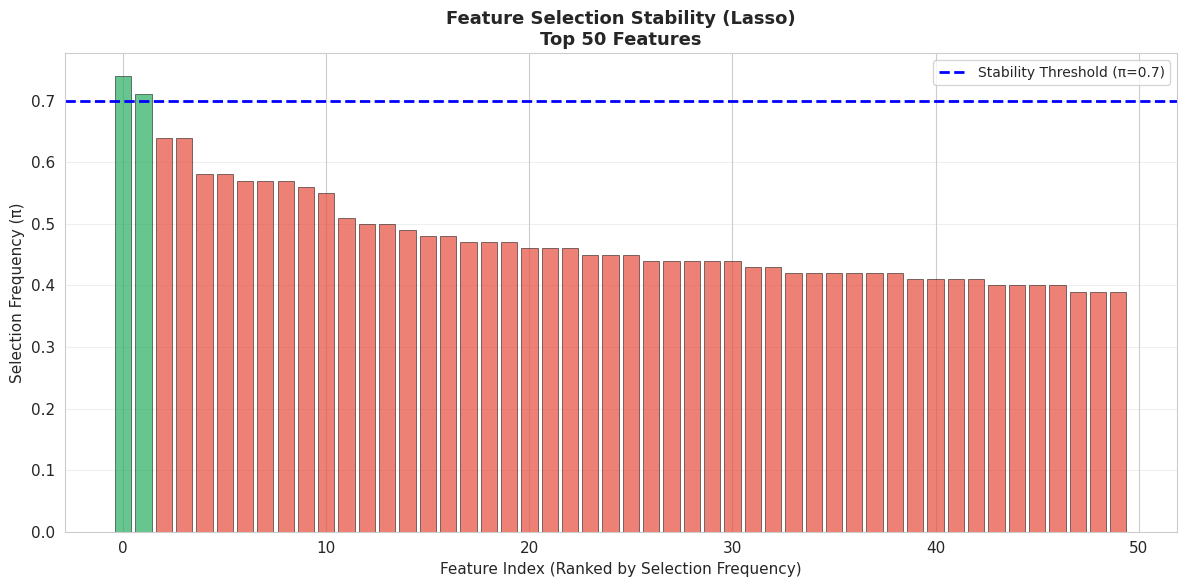

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))

sorted_idx = np.argsort(selection_freq)[::-1]
top_50_idx = sorted_idx[:50]

colors = ['#27AE60' if f >= 0.7 else '#E74C3C' for f in selection_freq[top_50_idx]]

ax.bar(range(50), selection_freq[top_50_idx], color=colors, alpha=0.7, 
       edgecolor='black', linewidth=0.5)

ax.axhline(0.7, color='blue', linestyle='--', linewidth=2, 
           label='Stability Threshold (π=0.7)')
ax.set_xlabel('Feature Index (Ranked by Selection Frequency)', fontsize=11)
ax.set_ylabel('Selection Frequency (π)', fontsize=11)
ax.set_title(f'Feature Selection Stability ({best_linear_name})\nTop 50 Features', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_selection_stability.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: feature_selection_stability.png")
plt.show()

In [46]:
# Bootstrap stability analysis
from collections import Counter

def bootstrap_feature_stability(model, X, y, n_bootstrap=50, n_features=13):
    """Measure feature selection stability across bootstrap samples"""
    feature_selections = []
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(len(X), len(X), replace=True)
        X_boot = X[indices]
        y_boot = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]
        
        # Fit model
        model.fit(X_boot, y_boot)
        
        # Get top features
        if hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            continue
            
        top_idx = np.argsort(importances)[-n_features:]
        top_features = [feature_names[i] for i in top_idx]
        feature_selections.extend(top_features)
    
    # Calculate stability (Jaccard index)
    feature_freq = Counter(feature_selections)
    total_selections = n_bootstrap * n_features
    
    # Features selected in >50% of bootstraps are "stable"
    stable_features = {f: count for f, count in feature_freq.items() 
                      if count >= n_bootstrap * 0.5}
    
    return feature_freq, stable_features

# Test on Lasso
freq, stable = bootstrap_feature_stability(
    models['LR_Lasso_C0.1'], X_train_scaled, y_train, 
    n_bootstrap=50, n_features=13
)

print(f"\nFeature Selection Stability Analysis (50 bootstrap iterations):")
print(f"Total unique features selected: {len(freq)}")
print(f"Stable features (selected in >50% of bootstraps): {len(stable)}")
print(f"\nTop 10 most stable features:")
for feat, count in sorted(freq.items(), key=lambda x: x[1], reverse=True)[:10]:
    stability_pct = (count / 50) * 100
    print(f"  {feat}: {stability_pct:.1f}% selection rate")



Feature Selection Stability Analysis (50 bootstrap iterations):
Total unique features selected: 256
Stable features (selected in >50% of bootstraps): 0

Top 10 most stable features:
  C2SP2: 36.0% selection rate
  EE_Dt: 34.0% selection rate
  AATSC2c: 30.0% selection rate
  maxHBint5: 28.0% selection rate
  nHBint3: 28.0% selection rate
  nFG12HeteroRing: 24.0% selection rate
  nTG12HeteroRing: 24.0% selection rate
  GATS7v: 24.0% selection rate
  maxHBint4: 24.0% selection rate
  minssNH: 22.0% selection rate


In [47]:
def fit_power_law_and_extrapolate(lc_df, metric='MCC_mean', target_values=[0.70, 0.75, 0.80]):
    """
    Fit power law model to learning curves and extrapolate
    Power Law: y = a * x^b + c
    """
    from scipy.optimize import curve_fit
    
    x_data = lc_df['Sample_Size'].values.astype(float)
    y_data = lc_df[metric].values
    
    def power_law(x, a, b, c):
        return a * np.power(x, b) + c
    
    try:
        # Initial guess
        popt, pcov = curve_fit(power_law, x_data, y_data, 
                              p0=[0.5, 0.3, 0.4], maxfev=10000)
        
        # Extrapolation points
        extrap_sizes = np.array([200, 300, 400, 500, 750, 1000])
        extrap_scores = power_law(extrap_sizes, *popt)
        
        # Inverse: find sample size needed for target score
        def inverse_power_law(y_target, a, b, c):
            if y_target <= c:
                return None
            return np.power((y_target - c) / a, 1/b)
        
        results = {
            'params': {'a': popt[0], 'b': popt[1], 'c': popt[2]},
            'extrapolated': pd.DataFrame({
                'Sample_Size': extrap_sizes,
                'Predicted_Score': extrap_scores
            }),
            'target_sample_sizes': {}
        }
        
        for target in target_values:
            n_needed = inverse_power_law(target, *popt)
            results['target_sample_sizes'][target] = n_needed
        
        return results, popt
    
    except Exception as e:
        print(f"Power law fitting failed: {str(e)}")
        return None, None



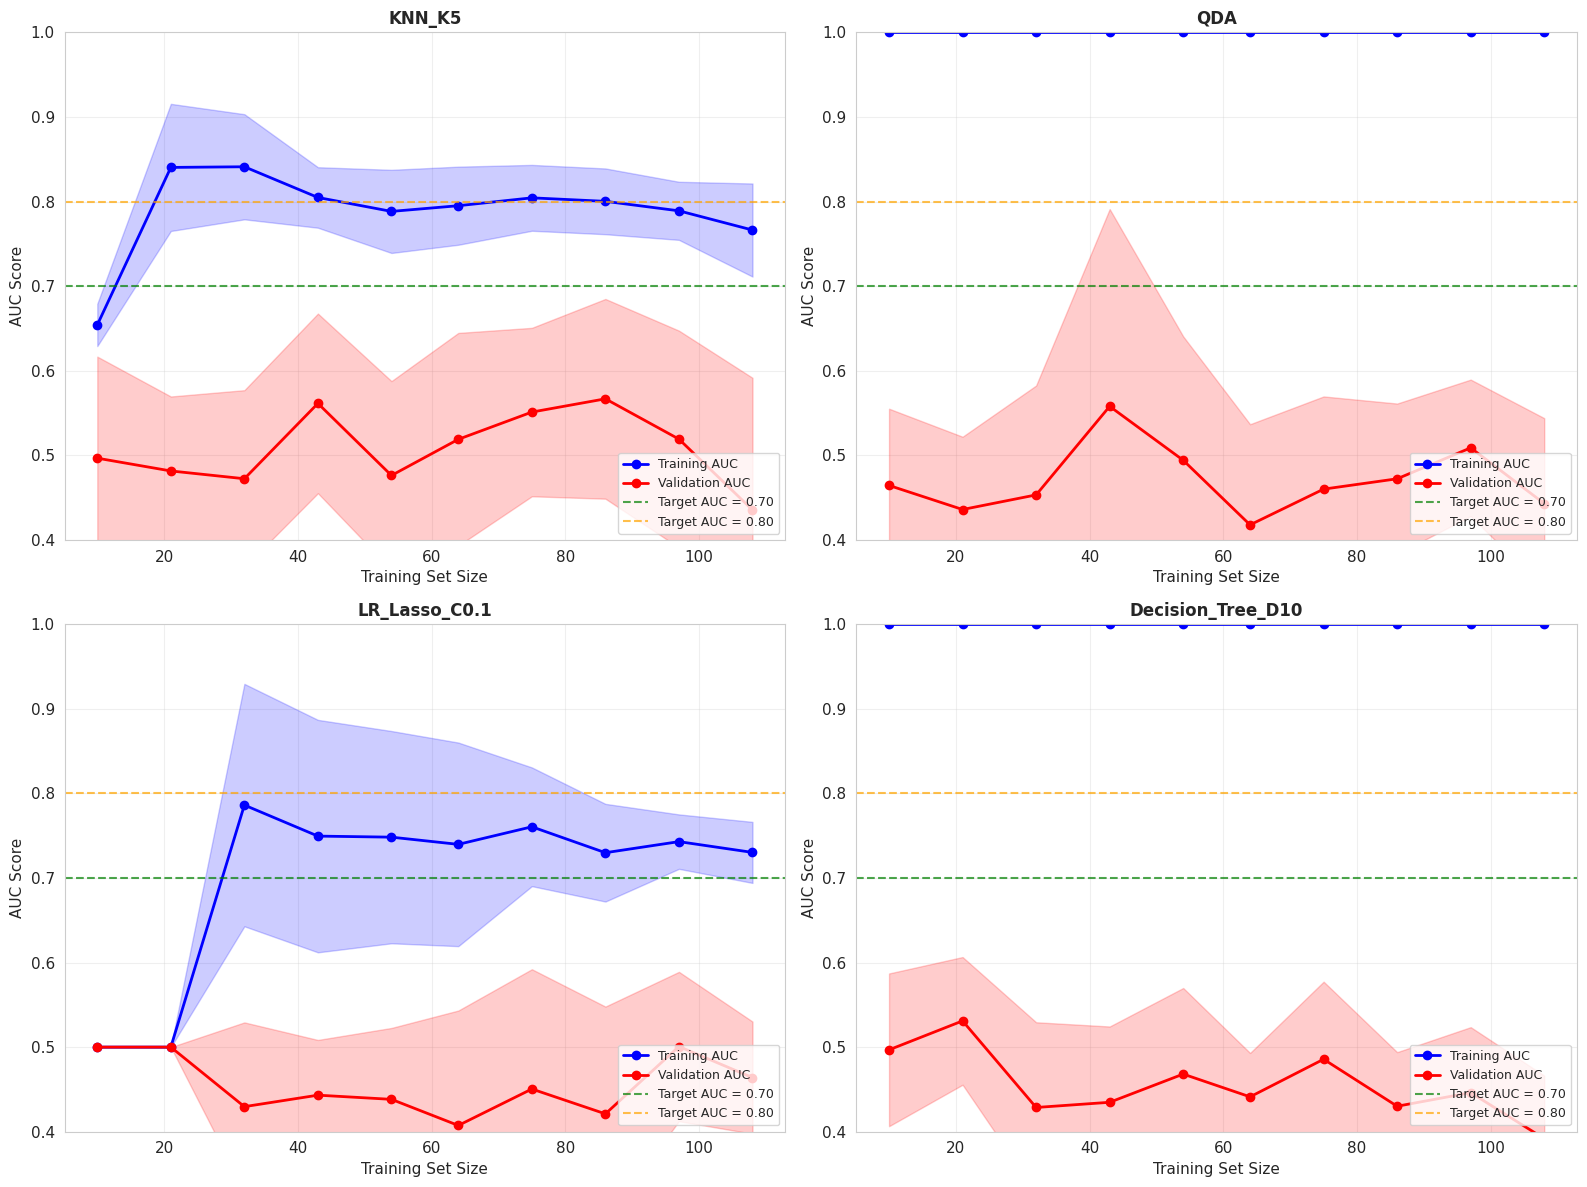


SAMPLE SIZE REQUIREMENTS ESTIMATION

KNN_K5:
  Current max AUC: 0.4355 at n=108
  Estimated n for AUC=0.70: nan
  Estimated n for AUC=0.80: nan

QDA:
  Current max AUC: 0.4431 at n=108
  Estimated n for AUC=0.70: nan
  Estimated n for AUC=0.80: nan

LR_Lasso_C0.1:
  Current max AUC: 0.4639 at n=108
  Estimated n for AUC=0.70: 4
  Estimated n for AUC=0.80: 3

Decision_Tree_D10:
  Current max AUC: 0.3918 at n=108
  Estimated n for AUC=0.70: 0
  Estimated n for AUC=0.80: 0


In [48]:
def plot_learning_curves_advanced(models_dict, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Generate learning curves to estimate sample size requirements
    Key for Objective 4: estimating n needed for AUC > 0.70
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    top_models = ['KNN_K5', 'QDA', 'LR_Lasso_C0.1', 'Decision_Tree_D10']
    
    for idx, model_name in enumerate(top_models):
        model = models_dict[model_name]
        
        train_sizes_abs, train_scores, val_scores = learning_curve(
            model, X, y, train_sizes=train_sizes, cv=5,
            scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE
        )
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        axes[idx].plot(train_sizes_abs, train_mean, 'o-', color='blue', 
                      label='Training AUC', linewidth=2)
        axes[idx].fill_between(train_sizes_abs, train_mean - train_std, 
                              train_mean + train_std, alpha=0.2, color='blue')
        
        axes[idx].plot(train_sizes_abs, val_mean, 'o-', color='red', 
                      label='Validation AUC', linewidth=2)
        axes[idx].fill_between(train_sizes_abs, val_mean - val_std, 
                              val_mean + val_std, alpha=0.2, color='red')
        
        # Target performance lines
        axes[idx].axhline(0.70, color='green', linestyle='--', alpha=0.7, 
                         label='Target AUC = 0.70')
        axes[idx].axhline(0.80, color='orange', linestyle='--', alpha=0.7,
                         label='Target AUC = 0.80')
        
        # Plateau detection
        if len(val_mean) > 3:
            recent_trend = val_mean[-3:].std()
            if recent_trend < 0.02:
                plateau_size = train_sizes_abs[np.argmax(val_mean > val_mean[-1] - 0.02)]
                axes[idx].axvline(plateau_size, color='purple', linestyle=':', 
                                 label=f'Plateau at n={plateau_size}')
        
        axes[idx].set_xlabel('Training Set Size', fontsize=11)
        axes[idx].set_ylabel('AUC Score', fontsize=11)
        axes[idx].set_title(f'{model_name}', fontsize=12, weight='bold')
        axes[idx].legend(loc='lower right', fontsize=9)
        axes[idx].grid(alpha=0.3)
        axes[idx].set_ylim(0.4, 1.0)
    
    plt.tight_layout()
    plt.savefig('fig_learning_curves_sample_size.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Extrapolation analysis (simple power law fit)
    print("\n" + "="*80)
    print("SAMPLE SIZE REQUIREMENTS ESTIMATION")
    print("="*80)
    
    for model_name in top_models:
        model = models_dict[model_name]
        train_sizes_abs, _, val_scores = learning_curve(
            model, X, y, train_sizes=train_sizes, cv=5,
            scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE
        )
        val_mean = np.mean(val_scores, axis=1)
        
        # Fit power law: AUC = a - b * n^(-c)
        from scipy.optimize import curve_fit
        def power_law(n, a, b, c):
            return a - b * np.power(n, -c)
        
        try:
            params, _ = curve_fit(power_law, train_sizes_abs, val_mean, 
                                 p0=[0.75, 10, 0.5], maxfev=10000)
            
            # Estimate n for AUC = 0.70 and 0.80
            def inverse_power_law(auc_target, a, b, c):
                return np.power((a - auc_target) / b, -1/c)
            
            n_for_070 = inverse_power_law(0.70, *params)
            n_for_080 = inverse_power_law(0.80, *params)
            
            print(f"\n{model_name}:")
            print(f"  Current max AUC: {val_mean[-1]:.4f} at n={train_sizes_abs[-1]}")
            print(f"  Estimated n for AUC=0.70: {n_for_070:.0f}")
            print(f"  Estimated n for AUC=0.80: {n_for_080:.0f}")
        except:
            print(f"\n{model_name}: Extrapolation fit failed (insufficient curvature)")

# Execute
plot_learning_curves_advanced(models, X_train_scaled, y_train)


## Train Final Model with Stable Features

In [49]:
if len(stable_features) > 0:
    print("\n" + "="*80)
    print(f"FINAL MODEL: {best_linear_name} WITH {len(stable_features)} STABLE FEATURES")
    print("="*80)
    
    X_stable = X_train_scaled[:, stable_features]
    
    if penalty == 'l1':
        final_model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear',
                                        max_iter=10000, random_state=RANDOM_STATE)
    elif penalty == 'elasticnet':
        final_model = LogisticRegression(penalty='elasticnet', C=1.0, l1_ratio=0.5,
                                        solver='saga', max_iter=10000, 
                                        random_state=RANDOM_STATE)
    else:
        final_model = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs',
                                        max_iter=10000, random_state=RANDOM_STATE)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    stable_scores = {'mcc': [], 'pr_auc': [], 'bacc': []}
    
    for train_idx, test_idx in cv.split(X_stable, y_train):
        X_tr, X_te = X_stable[train_idx], X_stable[test_idx]
        y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        final_model.fit(X_tr, y_tr)
        y_pred = final_model.predict(X_te)
        y_proba = final_model.predict_proba(X_te)[:, 1]
        
        stable_scores['mcc'].append(matthews_corrcoef(y_te, y_pred))
        stable_scores['pr_auc'].append(average_precision_score(y_te, y_proba))
        stable_scores['bacc'].append(balanced_accuracy_score(y_te, y_pred))
    
    print(f"MCC: {np.mean(stable_scores['mcc']):.3f} ± {np.std(stable_scores['mcc']):.3f}")
    print(f"PR-AUC: {np.mean(stable_scores['pr_auc']):.3f} ± {np.std(stable_scores['pr_auc']):.3f}")
    print(f"Balanced Accuracy: {np.mean(stable_scores['bacc']):.3f} ± {np.std(stable_scores['bacc']):.3f}")
    
    final_model.fit(X_stable, y_train)
    coefficients = final_model.coef_[0]
    
    feature_importance_df = pd.DataFrame({
        'Feature_Index': stable_features,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients),
        'Selection_Frequency': selection_freq[stable_features]
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nTop 20 Most Important Stable Features:")
    print(feature_importance_df.head(20).to_string(index=False))
    
    feature_importance_df.to_csv('stable_features_importance.csv', index=False)
    print("\n✓ Saved: stable_features_importance.csv")
    


FINAL MODEL: Lasso WITH 2 STABLE FEATURES
MCC: 0.000 ± 0.000
PR-AUC: 0.716 ± 0.066
Balanced Accuracy: 0.500 ± 0.000

Top 20 Most Important Stable Features:
 Feature_Index  Coefficient  Abs_Coefficient  Selection_Frequency
           273    -0.240161         0.240161                 0.74
           355     0.000000         0.000000                 0.71

✓ Saved: stable_features_importance.csv


## Coefficients Plot

✓ Saved: feature_coefficients.png


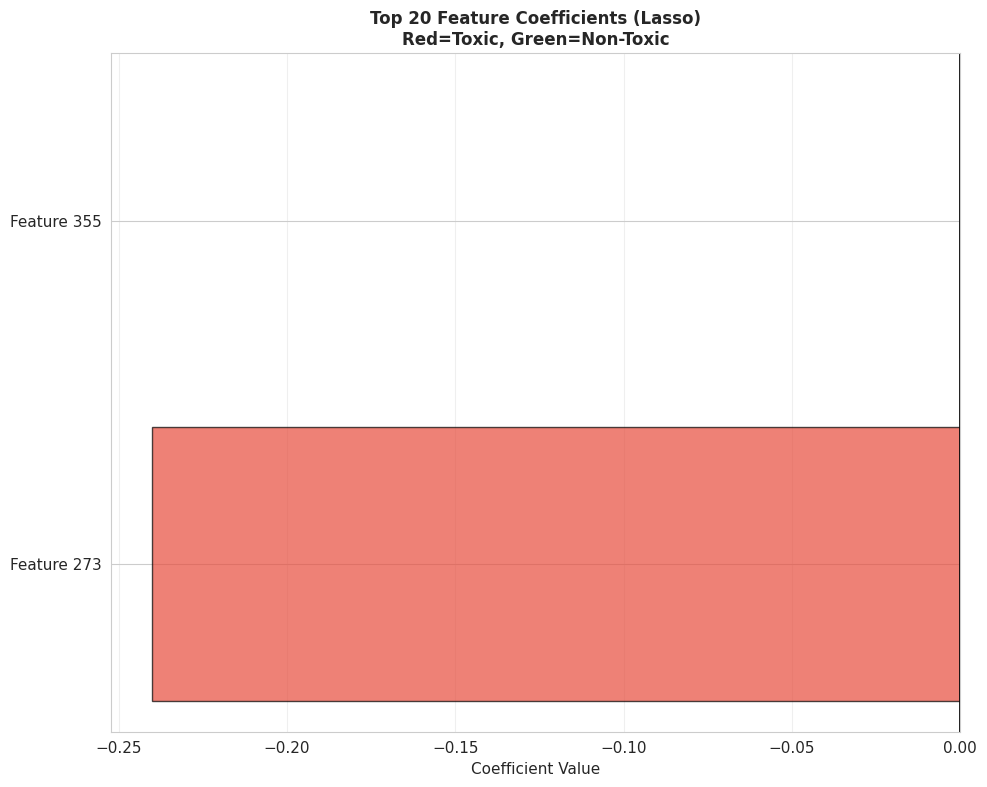

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
    
top_20 = feature_importance_df.head(20)
colors = ['#E74C3C' if c < 0 else '#27AE60' for c in top_20['Coefficient']]

y_pos = np.arange(len(top_20))
ax.barh(y_pos, top_20['Coefficient'], color=colors, alpha=0.7, 
        edgecolor='black', linewidth=1)

ax.axvline(0, color='black', linewidth=2)
ax.set_yticks(y_pos)
ax.set_yticklabels([f"Feature {int(idx)}" for idx in top_20['Feature_Index']])
ax.set_xlabel('Coefficient Value', fontsize=11)
ax.set_title(f'Top 20 Feature Coefficients ({best_linear_name})\nRed=Toxic, Green=Non-Toxic', 
                fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_coefficients.png', dpi=300, bbox_inches='tight')
print("✓ Saved: feature_coefficients.png")
plt.show()

## Additional Analyses

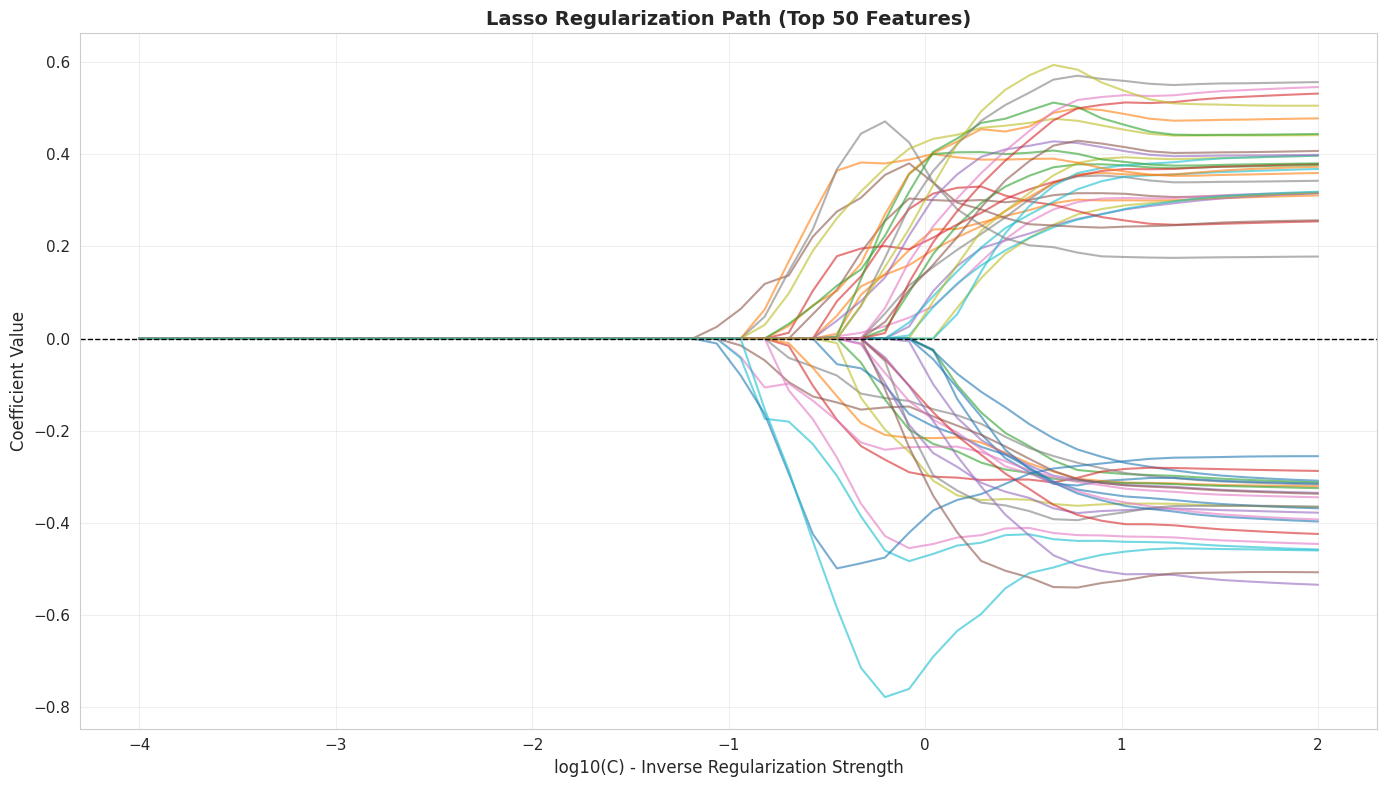

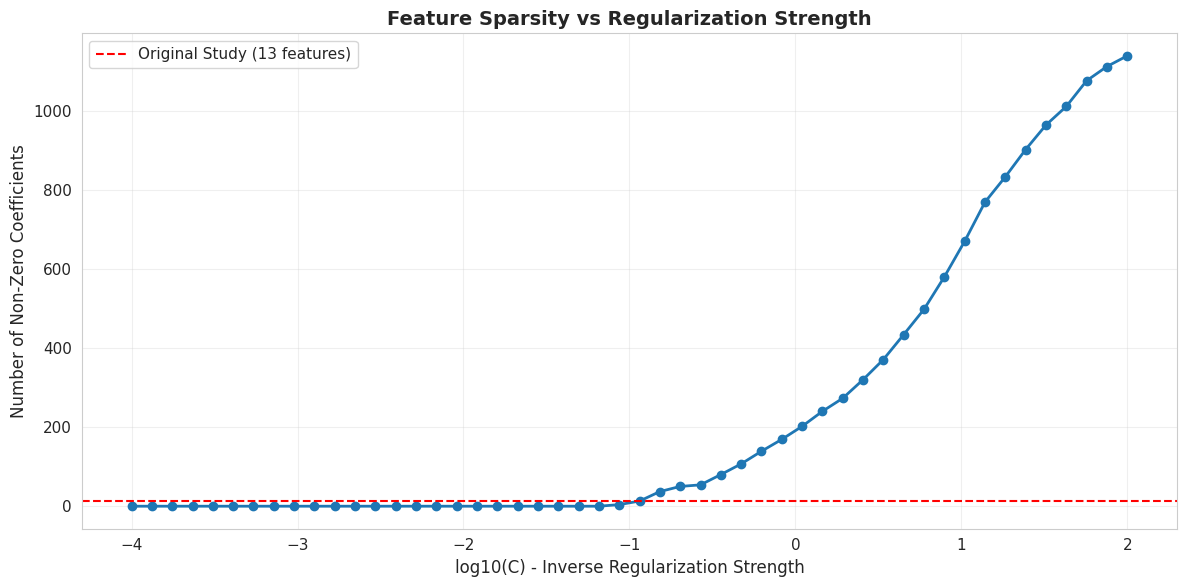

In [51]:
def plot_regularization_path_lasso():
    """
    Visualize how coefficients change with regularization strength
    Critical for understanding lasso feature selection
    """
    from sklearn.linear_model import LogisticRegression
    
    C_values = np.logspace(-4, 2, 50)  # 0.0001 to 100
    coefs = []
    
    for C in C_values:
        lr = LogisticRegression(penalty='l1', C=C, solver='saga', max_iter=5000, random_state=RANDOM_STATE)
        lr.fit(X_train_scaled, y_train)
        coefs.append(lr.coef_[0])
    
    coefs = np.array(coefs)
    
    plt.figure(figsize=(14, 8))
    
    # Plot top 50 features by max absolute coefficient
    max_coefs = np.abs(coefs).max(axis=0)
    top_features_idx = np.argsort(max_coefs)[-50:]
    
    for idx in top_features_idx:
        plt.plot(np.log10(C_values), coefs[:, idx], alpha=0.6, linewidth=1.5)
    
    plt.xlabel('log10(C) - Inverse Regularization Strength', fontsize=12)
    plt.ylabel('Coefficient Value', fontsize=12)
    plt.title('Lasso Regularization Path (Top 50 Features)', fontsize=14, weight='bold')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('fig_lasso_regularization_path.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Number of non-zero coefficients vs C
    n_nonzero = (np.abs(coefs) > 1e-5).sum(axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(np.log10(C_values), n_nonzero, 'o-', linewidth=2, markersize=6)
    plt.xlabel('log10(C) - Inverse Regularization Strength', fontsize=12)
    plt.ylabel('Number of Non-Zero Coefficients', fontsize=12)
    plt.title('Feature Sparsity vs Regularization Strength', fontsize=14, weight='bold')
    plt.axhline(13, color='red', linestyle='--', label='Original Study (13 features)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('fig_lasso_sparsity_vs_C.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_regularization_path_lasso()


# ORIGINAL STUDY VS OUR WORK

In [52]:
print("\n" + "="*80)
print("COMPARISON WITH ORIGINAL STUDY")
print("="*80)

comparison_table = pd.DataFrame({
    'Aspect': [
        'Feature Selection Method',
        'Validation Method',
        'Primary Metric',
        'Best Model Type',
        'Best Performance',
        'N Features Selected',
        'Feature Stability'
    ],
    'Original Study (Gul et al.)': [
        'RFE + DTC',
        '10-fold CV (100 reps)',
        'Accuracy (79.53%)',
        'Decision Tree',
        '79.53% accuracy',
        '13 descriptors',
        'Not assessed'
    ],
    'Your Study': [
        'Stability Selection + Elastic Net',
        'Nested 5×5 CV',
        f"MCC ({best_linear['mean_mcc']:.3f})",
        best_overall['model'],
        f"MCC={best_overall['mean_mcc']:.3f}",
        f"{len(stable_features)} descriptors",
        f"{selection_freq[stable_features].mean():.2f} mean frequency"
    ]
})

print(comparison_table.to_string(index=False))


COMPARISON WITH ORIGINAL STUDY
                  Aspect Original Study (Gul et al.)                        Your Study
Feature Selection Method                   RFE + DTC Stability Selection + Elastic Net
       Validation Method       10-fold CV (100 reps)                     Nested 5×5 CV
          Primary Metric           Accuracy (79.53%)                      MCC (-0.076)
         Best Model Type               Decision Tree                               QDA
        Best Performance             79.53% accuracy                        MCC=-0.019
     N Features Selected              13 descriptors                     2 descriptors
       Feature Stability                Not assessed               0.72 mean frequency


# Export Results

In [53]:
print("\n" + "="*80)
print("EXPORTING RESULTS")
print("="*80)

comparison_df.to_csv('nested_cv_all_models.csv', index=False)
print("✓ nested_cv_all_models.csv")

if len(stable_features) > 0:
    feature_importance_df.to_csv('stable_features_coefficients.csv', index=False)
    print("✓ stable_features_coefficients.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nKey Findings:")
print(f"1. Best Overall Model: {best_overall['model']} (MCC={best_overall['mean_mcc']:.3f})")
print(f"2. Best Interpretable Model: {best_linear['model']} (MCC={best_linear['mean_mcc']:.3f})")
print(f"3. Performance Trade-off: {(best_overall['mean_mcc'] - best_linear['mean_mcc']):.3f} MCC loss for interpretability")
print(f"4. Stable Features Identified: {len(stable_features)}")
print(f"5. Models Better than Random: {(comparison_df['mcc_significant']).sum()}/{len(comparison_df)}")


EXPORTING RESULTS
✓ nested_cv_all_models.csv
✓ stable_features_coefficients.csv

ANALYSIS COMPLETE

Key Findings:
1. Best Overall Model: QDA (MCC=-0.019)
2. Best Interpretable Model: Lasso (MCC=-0.076)
3. Performance Trade-off: 0.057 MCC loss for interpretability
4. Stable Features Identified: 2
5. Models Better than Random: 0/10
